# Tritonlytics Multilabel Classification - Sentiment

Experiments related to building a LM and multilabel classification model for survey comments captured in the Tritonlytics survey delivery system

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
from fastai.text import *   # Quick accesss to NLP functionality
from fastai.callbacks import *

import pdb
from tritonlytics import Metrics as metrics_util, DataGeneration as dg_util, PandasUtil as pd_util
from tritonlytics.evaluation import *
from tritonlytics.callbacks import RocAucEvaluation

import dill as pickle

import spacy
spacy_en = spacy.load('en')
spacy_es = spacy.load('es')

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [3]:
print(f'fastai version: {__version__}')

fastai version: 1.0.57


In [4]:
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Utility methods

In [5]:
def convert_to_snakecase(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('__', '_') 

In [6]:
# https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view : apostrophe lookup dict
appos_regex_repl = {
    r"\baren't\b" : "are not",
    r"\bcan't\b" : "cannot",
    r"\bcouldn't\b" : "could not",
    r"\bdidn't\b" : "did not",
    r"\bdoesn't\b" : "does not",
    r"\bdon't\b" : "do not",
    r"\bhadn't\b" : "had not",
    r"\bhasn't\b" : "has not",
    r"\bhaven't\b" : "have not",
    r"\bhe'd\b" : "he would",
    r"\bhe'll\b" : "he will",
    r"\bhe's\b" : "he is",
    r"\bi'd\b" : "I would",
    r"\bi'd\b" : "I had",
    r"\bi'll\b" : "I will",
    r"\bi'm\b" : "I am",
    r"\bisn't\b" : "is not",
    r"\bits\b" : "it is",
    r"\bit's\b" : "it is",
    r"\bit'll\b" : "it will",
    r"\bi've\b" : "I have",
    r"\blet's\b" : "let us",
    r"\bmightn't\b" : "might not",
    r"\bmustn't\b" : "must not",
    r"\bshan't\b" : "shall not",
    r"\bshe'd\b" : "she would",
    r"\bshe'll\b" : "she will",
    r"\bshe's\b" : "she is",
    r"\bshouldn't\b" : "should not",
    r"\bthat's\b" : "that is",
    r"\bthere's\b" : "there is",
    r"\bthey'd\b" : "they would",
    r"\bthey'll\b" : "they will",
    r"\bthey're\b" : "they are",
    r"\bthey've\b" : "they have",
    r"\bwe'd\b" : "we would",
    r"\bwe're\b" : "we are",
    r"\bweren't\b" : "were not",
    r"\bwe've\b" : "we have",
    r"\bwhat'll\b" : "what will",
    r"\bwhat're\b" : "what are",
    r"\bwhat's\b" : "what is",
    r"\bwhat've\b" : "what have",
    r"\bwhere's\b" : "where is",
    r"\bwho'd\b" : "who would",
    r"\bwho'll\b" : "who will",
    r"\bwho're\b" : "who are",
    r"\bwho's\b" : "who is",
    r"\bwho've\b" : "who have",
    r"\bwon't\b" : "will not",
    r"\bwouldn't\b" : "would not",
    r"\byou'd\b" : "you would",
    r"\byou'll\b" : "you will",
    r"\byou're\b" : "you are",
    r"\byou've\b" : "you have",
    r"\b're\b" : " are",
    r"\bwasn't\b" : "was not",
    r"\bwe'll\b" : "will",
    r"\bdidn't\b" : "did not",
    r"\btryin'\b" : "trying"
}

In [7]:
# based on https://www.kaggle.com/prashantkikani/pooled-gru-with-preprocessing
emoji_str_repls = {
    "&lt;3": " love ",
    ":]" : " happy ",
    "=)" : " happy ",
    "8)": " happy ",
    ":-)": " happy ",
    ":)": " happy ",
    "(-:": " happy ",
    "(:": " happy ",
    ":&gt;": " happy ",
    ":')": " happy ",
    "(:" : " happy ",
    ":d": " laughing ",
    ":dd": " laughing ",
    ";-)" : " wink ",
    ";)": " wink ",
    ":p": " playful ",
    ":o" : " surprise ",
    ":-(": " sad ",
    ":(": " sad ",
    "=(" : " sad ",
    "):" : " sad ",
    ":/": " skeptical ",
    ":s": " skeptical ",
    ":-s": " skeptical ",
    "^^": " nervous ",
    "^_^": " nervous ",
    "-_-" : " shame ",
}

In [8]:
spelling_regex_repls = {
    # abbreviations
    r"\bacctg\b" : "acct",
    r"\badd'l\b" : "additional",
    r"\br\s\b": "are",
    r"\bu\s\b": "you ",
    r"\b\sm\s\b ": "am",
    r"'cause\b" : "because",
    r"\b(ha)+\b": "haha",
    r"\b(he)+\b": "haha",
    r"\bya+y\b": "yay",
    r"\bwa+y\b": "way",
    r"\bf'real\b" : "for real",
    r"\bgr8\b" : "great",
    r"\bintl\b" : "int'l",
    # common misspellings
    r"\bbailable\b" : "available",
    r"\babilty\b" : "ability",
    r"\babsolutly\b" : "absolutely",
    r"\babsoultely\b" : "absolutely",
    r"\bacces\b" : "access",
    r"\baccesability\b" : "accessibility",
    r"\baccesbility\b" : "accessibility",
    r"\baccesibility\b" : "accessibility",
    r"\baccessability\b" : "accessibility",
    r"\baccessbility\b" : "accessibility",
    r"\baccesable\b" : "accessible",
    r"\baccesible\b" : "accessible",
    r"\baccessable\b" : "accessible",
    r"\bacessible\b" : "accessible",
    r"\bassessable\b" : "availability",
    r"\baccidently\b" : "accidentally",
    r"\baccomadate\b" : "accommodate",
    r"\baccomdate\b" : "accommodate",
    r"\baccomidate\b" : "accommodate",
    r"\baccomodate\b" : "accommodate",
    r"\baccomadating\b" : "accommodating",
    r"\baccomidating\b" : "accommodating",
    r"\baccomodating\b" : "accommodating",
    r"\baccomadations\b" : "accommodations",
    r"\baccomodation\b" : "accommodation",
    r"\baccouting\b" : "accounting",
    r"\baccross\b" : "across",
    r"\badd'l\b" : "additional",
    r"\badditonal\b" : "additional",
    r"\baddtionally\b" : "additionally",
    r"\badminstration\b" : "administration",
    r"\badminstrative\b" : "administrative",
    r"\badminstrator\b" : "administrator",
    r"\badress\b" : "address",
    r"\badvancment\b" : "advancement",
    r"\badvertized\b" : "advertised",
    r"\bafforable\b" : "affordable",
    r"\bafordable\b" : "affordable",
    r"\bafterall\b" : "after all",
    r"\bafterhours\b" : "after hours",
    r"\baggresive\b" : "aggressive",
    r"\bagressive\b" : "aggressive",
    r"\bagressions\b" : "aggressions",
    r"\balittle\b" : "a little",
    r"\balll\b" : "all",
    r"\balloted\b" : "allotted",
    r"\ballthough\b" : "although",
    r"\balthought\b" : "although",
    r"\ballways\b" : "always",
    r"\balos\b" : "also",
    r"\balot\b" : "a lot",
    r"\balotted\b" : "allotted",
    r"\bammount\b" : "amount",
    r"\bammounts\b" : "amounts",
    r"\bamoung\b" : "among",
    r"\bamoungst\b" : "amongst",
    r"\bannouncment\b" : "announcement",
    r"\baparments\b" : "apartments",
    r"\bapparrel\b" : "apparel",
    r"\bappartment\b" : "apartment",
    r"\bappriciate\b" : "appreciate",
    r"\bassitance\b" : "assistance",
    r"\bassitant\b" : "assistant",
    r"\batleast\b" : "at least",
    r"\battentative\b" : "attentive",
    r"\battrocious\b" : "atrocious",
    r"\bavaiable\b" : "available",
    r"\bavaible\b" : "available",
    r"\bavailabe\b" : "available",
    r"\bavailble\b" : "available",
    r"\bavailiable\b" : "available",
    r"\bavailible\b" : "available",
    r"\bavaliable\b" : "available",
    r"\bavalible\b" : "available",
    r"\bavilable\b" : "available",
    r"\bavailiability\b" : "availability",
    r"\bavailabiltiy\b" : "availability",
    r"\bavailabilty\b" : "availability",
    r"\bavailablility\b" : "availability",
    r"\bavailablity\b" : "availability",
    r"\bavailibility\b" : "availability",
    r"\bavaliability\b" : "availability",
    r"\bavaliablity\b" : "availability",
    r"\bavalibility\b" : "availability",
    r"\bactivies\b" : "activities",
    r"\bactivites\b" : "activities",
    r"\bactualy\b" : "actually",
    r"\bacutally\b" : "actually",
    r"\bammenities\b" : "amenities",
    r"\bantoher\b" : "another",
    r"\bassitant\b" : "assistant",
    r"\baswell\b" : "as well",
    r"\baweful\b" : "awful",
    r"\bawfull\b" : "awful",
    r"\bawsome\b" : "awesome",
    r"\bbeacuse\b" : "because",
    r"\bbearly\b" : "barely",
    r"\bbeaurocracy\b" : "bureaucracy",
    r"\bbeaurocratic\b" : "bureaucratic",
    r"\bbecasue\b" : "because",
    r"\bbecuase\b" : "because",
    r"\bbecuse\b" : "because",
    r"\bbefor\b" : "before",
    r"\bbeggining\b" : "beginning",
    r"\bbegining\b" : "beginning",
    r"\bbeleive\b" : "believe",
    r"\bbelive\b" : "believe",
    r"\bbenificial\b" : "beneficial",
    r"\bbenifit\b" : "benefit",
    r'\bbugetary\b' : "budgetary",
    r'\bbuiding\b' : "building",
    r'\bbuidling\b' : "building",
    r'\bbuisness\b' : "business",
    r'\bbuliding\b' : "building",
    r"\bbureacracy\b" : "bureaucracy",
    r"\bburitto\b" : "burrito",
    r"\bbussiness\b" : "business",
    r"\bcalender\b" : "calendar",
    r"\bcan;t\b" : "can't",
    r"\bcasher\b" : "cashier",
    r'\bcatagories\b' : "categories",
    r'\bcatagory\b' : "category",
    r"\bcheapter\b" : "cheaper",
    r"\bcheeper\b" : "cheaper",
    r'\bclasss\b' : "clas",
    r'\bclassses\b' : "classes",
    r"\bcleaniness\b" : "cleanliness",
    r"\bcmapus\b" : "campus",
    r'\bcofee\b' : "coffee",
    r'\bcoffe\b' : "coffee",
    r'\bcollegue\b' : "colleague",
    r'\bcoment\b' : "comment",
    r'\bcoments\b' : "comments",
    r'\bcomming\b' : "coming",
    r'\bcommittment\b' : "commitment",
    r'\bcommment\b' : "comment",
    r'\bcommuication\b' : "communication",
    r'\bcommunter\b' : "commuter",
    r'\bcommunters\b' : "commuters",
    r'\bcomotion\b' : "commotion",
    r'\bcomparision\b' : "comparison",
    r'\bcompatability\b' : "compatibility",
    r'\bcompatable\b' : "compatible",
    r'\bcompetative\b' : "competitive",
    r'\bcompetetive\b' : "competitive",
    r'\bcompetive\b' : "competitive",
    r'\bcompletly\b' : "completely",
    r"\bcomraderie\b" : "camaraderie",
    r'\bcomradery\b' : "camaraderie",
    r'\bcomunication\b' : "communication",
    r'\bcomunity\b' : "community",
    r'\bconcious\b' : "conscious",
    r'\bcondusive\b' : "conducive",
    r'\bconection\b' : "connection",
    r"\bconfortable\b" : "comfortable",
    r'\bconsistant\b' : "consistent",
    r'\bconsistantly\b' : "consistently",
    r'\bconsistenly\b' : "consistently",
    r'\bcontinously\b' : "continuously",
    r'\bcontruction\b' : "construction",
    r'\bconveinent\b' : "convenient",
    r'\bconveinient\b' : "convenient",
    r'\bconveniant\b' : "convenient",
    r'\bconveniece\b' : "convenience",
    r'\bconveninent\b' : "convenient",
    r'\bconvienance\b' : "convenience",
    r'\bconvienant\b' : "convenient",
    r'\bconvience\b' : "convenience",
    r'\bconvienence\b' : "convenience",
    r'\bconvienent\b' : "convenient",
    r'\bconvienet\b' : "convenient",
    r'\bconvienience\b' : "convenience",
    r'\bconvienient\b' : "convenient",
    r'\bconvient\b' : "convenient",
    r'\bconviently\b' : "conveniently",
    r'\bconvinence\b' : "convenience",
    r'\bconvinent\b' : "convenient",
    r'\bconvinience\b' : "convenience",
    r'\bconvinient\b' : "convenient",
    r'\bcorteous\b' : "courteous",
    r'\bcostodial\b' : "custodial",
    r'\bcoureous\b' : "courteous",
    r'\bcourtis\b' : "courteous",
    r'\bcouteous\b' : "courteous",
    r'\bcovenient\b' : "convenient",
    r'\bcroweded\b' : "crowded",
    r'\bcurteous\b' : "courteous",
    r'\bcurtesy\b' : "courtesy",
    r'\bcurtious\b' : "courteous",
    r"\bdeaprtment\b" : "department",
    r"\bdecission\b" : "decision",
    r'\bdefinately\b' : "definitely",
    r'\bdefinetely\b' : "definitely",
    r'\bdefinetly\b' : "definitely",
    r'\bdefinitley\b' : "definitely",
    r'\bdefinitly\b' : "definitely",
    r'\bdelievered\b' : "delivered",
    r'\bdeliverers\b' : "deliveries",
    r'\bdeparment\b' : "department",
    r'\bdeparments\b' : "department",
    r'\bdepartement\b' : "department",
    r"\bdepartment\(s\b" : "departments",
    r'\bdepartmet\b' : "department",
    r'\bdepratment\b' : "department",
    r"\bdeptartment\b" : "department",
    r'\bdescrimination\b' : "discrimination",
    r'\bdesireable\b' : "desirable",
    r"\bdiffernt\b" : "different",
    r"\bdiffrent\b" : "different",
    r'\bdinig\b' : "dining",
    r'\bdirverse\b' : "diverse",
    r'\bdisapointed\b' : "disappointed",
    r'\bdisapointing\b' : "disappointing",
    r'\bdisasterous\b' : "disastrous",
    r'\bdisatisfied\b' : "dissatisfied",
    r'\bdisbursment\b' : "disbursement",
    r'\bdisbursments\b' : "disbursements",
    r'\bdiscretely\b' : "discreetly",
    r'\bdiscusting\b' : "disgusting",
    r'\bdisfunctional\b' : "dysfunctional",
    r'\bdispensors\b' : "dispensers",
    r'\bdispersement\b' : "disbursement",
    r'\bdissapointed\b' : "disappointed",
    r'\bdissapointing\b' : "disappointing",
    r'\bdissapointment\b' : "disappointment",
    r'\bdissappointed\b' : "disappointed",
    r'\bdissappointing\b' : "disappointing",
    r'\bdissatified\b' : "dissatisfied",
    r'\bdiveristy\b' : "diversity",
    r'\bdivison\b' : "division",
    r'\bdivsion\b' : "division",
    r"\bdoens't\b" : "doesn't",
    r"\bdoes't\b" : "doesn't",
    r"\bdoesn;t\b" : "doesn't",
    r"\bdon;t\b" : "don't",
    r'\bdonot\b' : "do not",
    r"\bdosen't\b" : "doesn't",
    r"\bdosent\b" : "doesn't",
    r'\bdumbells\b' : "dumbbells",
    r'\bdurring\b' : "during",
    r"\beatting\b" : "eating",
    r"\beduation\b" : "education",
    r'\beffeciency\b' : "efficiency",
    r'\beffecient\b' : "efficient",
    r'\befficency\b' : "efficiency",
    r'\befficent\b' : "efficient",
    r'\beffiecient\b' : "efficient",
    r'\beimplying\b' : "implying",
    r'\bembarassed\b' : "embarrassed",
    r'\bembarassing\b' : "embarrassing",
    r'\bembarassment\b' : "embarrassment",
    r'\bemploee\b' : "employee",
    r'\bemploye\b' : "employee",
    r'\bemployee\(s\b' : "employees",
    r'\bemployeed\b' : "employed",
    r'\bemployement\b' : "employment",
    r'\bemployes\b' : "employees",
    r'\bemployess\b' : "employees",
    r'\bemplyee\b' : "employee",
    r'\bemplyees\b' : "employees",
    r'\bempolyees\b' : "employees",
    r'\bencoutered\b' : "encountered",
    r'\benought\b' : "enough",
    r'\benrollement\b' : "enrollment",
    r'\benviorment\b' : "environment",
    r'\benviornment\b' : "environment",
    r'\benvirnment\b' : "environment",
    r'\benviroment\b' : "environment",
    r'\benvironement\b' : "environment",
    r'\bequiped\b' : "equipped",
    r'\bespcially\b' : "especially",
    r'\bespecailly\b' : "especially",
    r'\bespecialy\b' : "especially",
    r'\bespeically\b' : "especially",
    r"\besthetically\b" : "aesthetically ",
    r"\bethinicity\b" : "ethnicity",
    r"\bevaulation\b" : "evaluation",
    r"\beventhough\b" : "even though",
    r'\beverday\b' : "every day",
    r'\beverthing\b' : "everything",
    r'\beveryones\b' : "everyones",
    r'\beverythings\b' : "everythings",
    r'\beveryway\b' : "every way",
    r'\beveyone\b' : "everyone",
    r'\beveything\b' : "everything",
    r'\bevrything\b' : "everything",
    r'\bexcelent\b' : "excellent",
    r'\bexcellant\b' : "excellent",
    r'\bexellent\b' : "excellent",
    r'\bexhorbitant\b' : "exorbitant",
    r'\bexistance\b' : "existence",
    r'\bexpecially\b' : "especially",
    r'\bexpensice\b' : "expensive",
    r'\bexpereince\b' : "experience",
    r'\bexperiance\b' : "experience",
    r'\bexperince\b' : "experience",
    r'\bexpierence\b' : "experience",
    r'\bexpirence\b' : "experience",
    r'\bexplaination\b' : "explanation",
    r'\bexremely\b' : "extremely",
    r'\bextemely\b' : "extremely",
    r'\bextention\b' : "extension",
    r'\bextermely\b' : "extremely",
    r'\bextreamly\b' : "extremely",
    r'\bextrememly\b' : "extremely",
    r'\bextremly\b' : "extremely",
    r"\bfacilites\b" : "facilities",
    r'\bfacilties\b' : "facilities",
    r'\bfacilty\b' : "facility",
    r'\bfaculity\b' : "faculty",
    r'\bfacutly\b' : "faculty",
    r'\bfiancial\b' : "financial",
    r"\bfinacial\b" : "financial",
    r"\bfirendly\b" : "friendly",
    r'\bflexability\b' : "flexibility",
    r'\bflexibilty\b' : "flexibility",
    r'\bflexiblity\b' : "flexibility",
    r"\bflourescent\b" : "fluorescent",
    r'\bfreindly\b' : "friendly",
    r'\bfreqency\b' : "frequency",
    r'\bfreqent\b' : "frequent",
    r'\bfriednly\b' : "friendly",
    r'\bfrusterating\b' : "frustrating",
    r'\bfrusturating\b' : "frustrating",
    r'\bfustrating\b' : "frustrating",
    r'\bgovenor\b' : "governor",
    r"\bgraffitti\b" : "graffiti",
    r"\bgrafitti\b" : "graffiti",
    r"\bgreatful\b" : "grateful",
    r"\bguarenteed\b" : "guaranteed",
    r"\bguidlines\b" : "guidelines",
    r"\bguranteed\b" : "guaranteed",
    r"\bhappend\b" : "happened",
    r'\bharrass\b' : "harass",
    r'\bharrassed\b' : "harassed",
    r'\bharrassing\b' : "harassing",
    r'\bharrassment\b' : "harassment",
    r"\bhavn't\b" : "haven't",
    r'\bhealtheir\b' : "healthier",
    r'\bhealthly\b' : "healthy",
    r'\bhealtier\b' : "healthier",
    r'\bhealty\b' : "healthy",
    r'\bheathy\b' : "healthy",
    r'\bheirarchy\b' : "hierarchy",
    r'\bhelful\b' : "helpful",
    r'\bhelpfull\b' : "helpful",
    r'\bhelpul\b' : "helpful",
    r'\bhighschool\b' : "high school",
    r'\bhighschools\b' : "high schools",
    r'\bhorendous\b' : "horrendous",
    r'\bhorible\b' : "horrible",
    r'\bhouseing\b' : "housing",
    r'\bi"m\b' : "i'm",
    r'\bi"ve\b' : "i've",
    r'\bimplimented\b' : "implemented",
    r'\bimporve\b' : "improve",
    r'\bimposible\b' : "impossible",
    r'\bimprovment\b' : "improvement",
    r'\bimprovments\b' : "improvements",
    r'\bincompetant\b' : "incompetent",
    r'\binconsistant\b' : "inconsistent",
    r'\binconveinent\b' : "nconvenient",
    r'\binconvience\b' : "inconvenience",
    r'\binconvienent\b' : "nconvenient",
    r'\binconvienient\b' : "nconvenient",
    r'\binconvient\b' : "nconvenient",
    r'\binconvinient\b' : "nconvenient",
    r'\bindentify\b' : "identify",
    r'\bindependant\b' : "independent",
    r'\bindividual\(s\b' : "individuals",
    r'\binforced\b' : "enforced",
    r'\binformaiton\b' : "information",
    r'\binformtion\b' : "information",
    r'\binfront\b' : "in front",
    r'\binnout\b' : "in-n-out",
    r'\binsentive\b' : "incentive",
    r'\binsufficent\b' : "insufficient",
    r'\binterenet\b' : "internet",
    r'\binterent\b' : "internet",
    r'\bintermural\b' : "intramural",
    r'\bintramurals\b' : "intramurals",
    r'\binvironment\b' : "environment",
    r'\bissue\(s\b' : "issues",
    r'\bit;s\b' : "it's",
    r'\bitem\(s\b' : "items",
    r"\bjob\(s\b" : "jobs",
    r'\bknowledable\b' : "knowledgeable",
    r'\bknowledeable\b' : "knowledgeable",
    r'\bknowledegable\b' : "knowledgeable",
    r'\bknowledgable\b' : "knowledgeable",
    r'\bknowledgably\b' : "knowledgeably",
    r'\bknowledgeably\b' : "knowledgeably",
    r'\bknowledgeble\b' : "knowledgeable",
    r'\bknowlegable\b' : "knowledgeable",
    r'\bknowlegeable\b' : "knowledgeable",
    r'\bliek\b' : "like",
    r'\blieke\b' : "like",
    r'\blimted\b' : "limited",
    r'\bmaintainance\b' : "maintenance",
    r'\bmaintaince\b' : "maintenance",
    r'\bmaintainence\b' : "maintenance",
    r'\bmaintanance\b' : "maintenance",
    r'\bmaintance\b' : "maintenance",
    r'\bmaintanence\b' : "maintenance",
    r'\bmaintenace\b' : "maintenance",
    r'\bmaintenances\b' : "maintenance",
    r'\bmaintence\b' : "maintenance",
    r'\bmaintenece\b' : "maintenance",
    r'\bmaintenence\b' : "maintenance",
    r'\bmaitenance\b' : "maintenance",
    r'\bmanager\(s\b' : "managers",
    r'\bmanagment\b' : "management",
    r'\bmanangement\b' : "management",
    r'\bmangement\b' : "management",
    r'\bmangers\b' : "managers",
    r'\bmanuever\b' : "maneuver",
    r'\bmintues\b' : "minutes",
    r'\bmoblie\b' : "mobile",
    r'\bmulitple\b' : "multiple",
    r'\bn\?a\b' : "n/a",
    r'\bna\b' : "n/a",
    r'\bneccessary\b' : "necessary",
    r'\bnecesary\b' : "necessary",
    r'\bneedes\b' : "needs",
    r'\bneeed\b' : "need",
    r'\bnonexistant\b' : "nonexistent",
    r'\bnothig\b' : "nothing",
    r'\bnothjng\b' : "nothing",
    r'\bnoticable\b' : "noticeable",
    r'\bobsurd\b' : "absurd",
    r'\bocassional\b' : "occasional",
    r'\boccassion\b' : "occasion",
    r'\boccassional\b' : "occasional",
    r'\boccassionally\b' : "occasionally",
    r'\boccassions\b' : "occasions",
    r'\boccations\b' : "occasions",
    r'\boccurances\b' : "occurrences",
    r'\boccured\b' : "occurred",
    r'\boccuring\b' : "occurring",
    r'\boccurr\b' : "occur",
    r'\bofcourse\b' : "of course",
    r'\bofferred\b' : "offered",
    r'\bopinon\b' : "opinion",
    r'\bopitions\b' : "options",
    r'\boportunities\b' : "opportunities",
    r'\bopperation\b' : "operation",
    r'\boppertunities\b' : "opportunities",
    r'\boppinion\b' : "opinion",
    r'\bopportunites\b' : "opportunities",
    r'\bopportunties\b' : "opportunities",
    r'\boppotunities\b' : "opportunities",
    r'\boppurtunities\b' : "opportunities",
    r'\boppurtunity\b' : "opportunity",
    r'\borgnized\b' : "organized",
    r'\boutragous\b' : "outrageous",
    r'\bpage\(s\b' : "pages",
    r'\bpakages\b' : "packages",
    r'\bparkibg\b' : "parking",
    r'\bparkig\b' : "parking",
    r'\bparkign\b' : "parking",
    r'\bparkinglots\b' : "parking lots",
    r'\bpartime\b' : "part-time",
    r'\bparttime\b' : "part-time",
    r'\bpatroling\b' : "patrolling",
    r'\bpeopel\b' : "people",
    r'\bpermitt\b' : "permit",
    r'\bperson\(s\b' : "persons",
    r'\bpersonel\b' : "personnel",
    r'\bpersonell\b' : "personnel",
    r'\bpharamcy\b' : "pharmacy",
    r'\bpleasent\b' : "pleasant",
    r'\bplently\b' : "plenty",
    r'\bplesant\b' : "pleasant",
    r'\bpositon\b' : "position",
    r'\bposses\b' : "possess",
    r'\bpossition\b' : "position",
    r'\bpostion\b' : "position",
    r'\bpostions\b' : "positions",
    r'\bpostition\b' : "position",
    r'\bpostive\b' : "positive",
    r'\bpractioner\b' : "practitioner",
    r'\bpractioners\b' : "practitioners",
    r'\bprefered\b' : "preferred",
    r'\bpreferrably\b' : "preferably",
    r'\bpreform\b' : "perform",
    r'\bpreforming\b' : "performing",
    r'\bpricess\b' : "prices",
    r'\bpriciples\b' : "principles",
    r'\bpricy\b' : "pricey",
    r'\bprking\b' : "parking",
    r'\bproceedures\b' : "procedures",
    r'\bprocurment\b' : "procurement",
    r'\bprofessionaly\b' : "professionally",
    r'\bproffessional\b' : "professional",
    r'\bproffit\b' : "profit",
    r'\bprofitt\b' : "profit",
    r'\bprogam\b' : "program",
    r'\bpromissed\b' : "promised",
    r'\bpublically\b' : "publicly",
    r'\bqucik\b' : "quick",
    r'\bquestion\(s\b' : "questions",
    r'\bquestionaire\b' : "questionnaire",
    r'\breall\b' : "really",
    r'\brealy\b' : "really",
    r'\breccomend\b' : "recommend",
    r'\breccommend\b' : "recommend",
    r'\breceieve\b' : "receive",
    r'\breciept\b' : "receipt",
    r'\breciepts\b' : "receipts",
    r'\brecieve\b' : "receive",
    r'\brecieved\b' : "received",
    r'\brecieves\b' : "receives",
    r'\brecieving\b' : "receiving",
    r'\brecived\b' : "received",
    r'\brecomend\b' : "recommend",
    r'\brecomended\b' : "recommended",
    r'\brediculous\b' : "ridiculous",
    r'\brediculously\b' : "ridiculously",
    r'\brefered\b' : "referred",
    r'\brefering\b' : "referring",
    r'\bregeants\b' : "regents",
    r'\bregistar\b' : "regisrtar",
    r'\bregistars\b' : "regisrtars",
    r'\bregulary\b' : "regularly",
    r'\breimbursment\b' : "reimbursement",
    r'\breponse\b' : "response",
    r'\breponsive\b' : "responsive",
    r'\brepresentitive\b' : "representative",
    r'\breserach\b' : "research",
    r'\bresonable\b' : "reasonable",
    r'\bresouces\b' : "resources",
    r'\bresourses\b' : "resources",
    r'\bresponsed\b' : "responded",
    r'\bresponsibilites\b' : "responsibilites",
    r'\bresponsiblities\b' : "responsibilites",
    r'\bresponsiblity\b' : "responsibility",
    r'\brestaraunts\b' : "restaurants",
    r'\brestraunts\b' : "restaurants",
    r'\brestuarant\b' : "restaurant",
    r'\brestuarants\b' : "restaurants",
    r'\bresturant\b' : "restaurant",
    r'\bresturants\b' : "restaurants",
    r'\bridiculus\b' : "ridiculous",
    r'\briduculous\b' : "ridiculous",
    r'\broomate\b' : "roommate",
    r'\broomates\b' : "roommates",
    r'\bsaleries\b' : "salaries",
    r'\bsandwhich\b' : "sandwich",
    r'\bsandwhiches\b' : "sandwiches",
    r'\bsandwitches\b' : "sandwiches",
    r'\bsatifaction\b' : "satisfaction",
    r'\bsatified\b' : "satisfisatisfieded",
    r'\bsattelite\b' : "satellite",
    r'\bsceience\b' : "science",
    r'\bschedual\b' : "schedule",
    r'\bseemless\b' : "seamless",
    r'\bselction\b' : "selection",
    r'\bsenority\b' : "seniority",
    r'\bsensative\b' : "sensitive",
    r'\bsensored\b' : "censored",
    r'\bseperate\b' : "separate",
    r'\bseperation\b' : "separation",
    r'\bserivce\b' : "service",
    r'\bserivces\b' : "services",
    r'\bserive\b' : "service",
    r'\bserives\b' : "services",
    r'\bservicesi\b' : "services",
    r'\bservidces\b' : "services",
    r'\bservive\b' : "survive",
    r'\bservives\b' : "survives",
    r'\bseverly\b' : "severely",
    r'\bsevice\b' : "service",
    r'\bsevices\b' : "services",
    r'\bshcool\b' : "school",
    r'\bshoud\b' : "should",
    r'\bshoudl\b' : "should",
    r'\bshutttle\b' : "shuttle",
    r'\bsimiliar\b' : "similar",
    r'\bsomeitmes\b' : "sometimes",
    r'\bsomeone\(s\b' : "someones",
    r'\bsomeones\b' : "someones",
    r'\bsometiems\b' : "sometimes",
    r'\bsomone\b' : "someone",
    r'\bsomthing\b' : "something",
    r'\bsophmore\b' : "sophomore",
    r'\bspecialy\b' : "especially",
    r'\bstafff\b' : "staff",
    r'\bstatment\b' : "statement",
    r'\bstong\b' : "strong",
    r'\bstongly\b' : "strongly",
    r'\bstoping\b' : "stopping",
    r'\bstrabucks\b' : "starbucks",
    r'\bstressfull\b' : "stressful",
    r'\bstructure\(s\b' : "structures",
    r'\bstucture\b' : "structure",
    r'\bstuctures\b' : "structures",
    r'\bstuden\b' : "student",
    r'\bstudent\(s\b' : "students",
    r'\bstudetns\b' : "students",
    r'\bstudnet\b' : "student",
    r'\bstudnets\b' : "students",
    r'\bsucess\b' : "success",
    r'\bsudent\b' : "student",
    r'\bsudents\b' : "students",
    r'\bsuperintendant\b' : "superintendent",
    r'\bsuperviser\b' : "supervisor",
    r'\bsupervisor\(s\b' : "supervisors",
    r'\bsupervisores\b' : "supervisors",
    r'\bsuport\b' : "support",
    r'\bsupples\b' : "supplies",
    r'\bsuppossed\b' : "supposed",
    r'\bsuprised\b' : "surprised",
    r'\bsuvey\b' : "survey",
    r'\bsytem\b' : "system",
    r'\bthats\b' : "that's",
    r"\bthe're\b" : "they're",
    r'\btheives\b' : "thieves",
    r'\bthiefs\b' : "thieves",
    r'\bthreating\b' : "threatening",
    r'\bthroughly\b' : "thoroughly",
    r'\bthrought\b' : "throughout",
    r'\bthroughtout\b' : "throughout",
    r'\btodays\b' : "today's",
    r'\btraing\b' : "training",
    r'\btrainning\b' : "training",
    r'\btranfers\b' : "transfers",
    r'\btransfered\b' : "transferred",
    r'\btransfering\b' : "transferring",
    r'\btransporation\b' : "transportation",
    r'\btransportaion\b' : "transportation",
    r'\btransportations\b' : "transportations",
    r'\btransportion\b' : "transportation",
    r'\btrashbags\b' : "trash bags",
    r'\btrashcans\b' : "trash cans",
    r'\btremedously\b' : "tremendously",
    r'\btshirt\b' : "t-shirt",
    r'\btshirts\b' : "t-shirts",
    r'\btution\b' : "tuition",
    r'\btutition\b' : "tuition",
    r'\bunaccessible\b' : "inaccessible",
    r'\bunconvenient\b' : "inconvenient",
    r'\bunecessary\b' : "unnecessary",
    r'\bunflexible\b' : "inflexible",
    r'\bunforseen\b' : "unforeseen",
    r'\buniverisity\b' : "university",
    r'\buniveristy\b' : "university",
    r'\buniverity\b' : "university",
    r'\bunknowledgeable\b' : "unknowledgable",
    r'\bunneccessary\b' : "unnecessary",
    r'\bunrealiable\b' : "unreliable",
    r'\buntill\b' : "until",
    r'\bunversity\b' : "university",
    r'\buseability\b' : "usability",
    r'\busefull\b' : "useful",
    r'\bususally\b' : "usually",
    r'\bvaccum\b' : "vacuum",
    r'\bvaccuum\b' : "vacuum",
    r'\bvaction\b' : "vacation",
    r'\bvacume\b' : "vacuum",
    r'\bvariaty\b' : "variety",
    r'\bvarities\b' : "varieties",
    r'\bvarity\b' : "variety",
    r'\bvegeterian\b' : "vegetarian",
    r'\bvegitarian\b' : "vegetarian",
    r'\bvegitarians\b' : "vegetarians",
    r'\bvegtables\b' : "vegetables",
    r'\bventillation\b' : "ventilation",
    r'\bveriety\b' : "variety",
    r'\bvisted\b' : "visited",
    r'\bvistor\b' : "visitor",
    r'\bvistors\b' : "visitors",
    r'\bweeekends\b' : "weekends",
    r'\bwierd\b' : "weird",
    r'\bwirless\b' : "wireless",
    r'\bwithdrawl\b' : "withdrawal",
    r'\bwoudl\b' : "would",
    r"\bwoudn't\b" : "wouldn't",
    r"\bthier\b" : "their",
    r"\bappartments\b" : "apartments",
    r"\bbenifits\b" : "benefits",
    r"\bexistant\b" : "existent",
    r"\bsaftey\b" : "safety",
    r'\bdon"t\b' : "don't",
}

In [9]:
weirdchar_str_repls = {
    "#39;" : "'",   
    'amp;' : '&',   
    '#146;' : "'",   
    'nbsp;' : ' ',   
    '#36;' : '$',   
    '\\n' : "\n",   
    'quot;' : "'",   
    '’' : "'",   
    "´" : "'",
    "`" : "'",
    '`' : "'", 
    '´' : "'", 
    '“' : '"',   
    '”' : '"',   
    '<br />' : "\n",   
    '\\"' : '"',   
    '<unk>' : 'u_n',   
    ' @.@ ' : '.',   
    ' @-@ ' : '-',   
    '\\' : ' \\ ',   
    '•' : '-'
}

In [10]:
# does regex replace making the substitution the same case
def re_replace(word, replacement, text):
    def func(match):
        g = match.group()
        if g.islower(): return replacement.lower()
        if g.istitle(): return replacement.title()
        if g.isupper(): return replacement.upper()
        return replacement      
    
    return re.sub(word, func, text, flags=re.I)

# define regex and string replacements
re_repls = {}  # e.g., { **spelling_regex_repls } 
str_repls = {} # e.g., { **weirdchar_str_repls }

def make_replacements(t:str) -> str:
    # replace based on regexs (keeping case) and then strings
    for k, v in re_repls.items(): t = re_replace(k, v, t)
    for k, v in str_repls.items(): t = t.replace(k, t)
    return t

# ensure am|pm is considered it own token (7:00pm > 7:00 pm, 7am-10pm > 7 am - 10 pm))
def fix_ampm(t:str) -> str:
    re_ampm = re.compile(r'(\d+)(am|pm|am\-|pm\-|a\.m\.|p\.m\.|a\.m\.\-|p\.m\.\-)')    
    return re_ampm.sub(r'\1 \2 ', t)

# try to handle places where a new sentence doesn't begin with a space (e.g., I like dogs.I like cats)
# without breaking apart things like urls and emails
def fix_sentence_ends(t:str) -> str:
    re_sentend = re.compile(r'(?<!www)\.((?!com|edu|org|net|m\b)[a-zA-Z]+)(?!(@|\.(com|edu|org|net)))\b') 
    return re_sentend.sub(r'. \1 ', t)

# separate hyphen|tilde if it is at beginning of letter/digit
def fix_hyphenated_words(t:str) -> str:
    re_hypword = re.compile(r'\s(\-+|~+)([a-zA-Z0-9])')
    return re_hypword.sub(r' \1 \2', t)


# prepend custom tokenization rules to defaults
custom_tok_rules = defaults.text_pre_rules + [make_replacements, fix_ampm, fix_sentence_ends, fix_hyphenated_words]

# use this customized Tokenizer for qualitative data
tokenizer = Tokenizer(pre_rules=custom_tok_rules)

## Configuration

In [11]:
# various default, LM, and classification paths
PATH = Path('../data')
CLEAN_DATA_PATH = Path('../data/clean')

LM_PATH = PATH/'lm'
CLS_PATH = PATH/'classification'
SENTIMENT_PATH = CLS_PATH/'sentiment'

(LM_PATH/'models').mkdir(parents=True, exist_ok=True)
(LM_PATH/'tmp').mkdir(exist_ok=True)

(SENTIMENT_PATH/'models').mkdir(parents=True, exist_ok=True)
(SENTIMENT_PATH/'tmp').mkdir(exist_ok=True)

In [12]:
# basic columns
lm_dtypes = { 
    'Id': int, 'QuestionAnsID': int, 'AnswerText': str, 'AnswerText_NonEnglish': str, 'Language': str,
    
    'SurveyID': int, 'SurveyTypeID': int, 'BenchmarkSurveyType': str, 'ClientId': str,'RspID': int,
    
    'QuestionCategoryAbbr': str, 'QuestionText': str, 'QuestionClass': str, 
    
    'QuestionCategoryID': float, 'QuestionReportAbbr': str, 'QuestionCategoryLabel': str, 
    'BenchmarkLevel1': str, 'BenchmarkLevel2': str, 'BenchmarkLevel3': str, 'ClientBenchmarkLevel': str,
    
    'GroupCode': float, 'GroupID': str, 
    'GroupLevel1Code': float, 'GroupLevel1Name': str,
    'GroupLevel2Code': float, 'GroupLevel2Name': str,
    'GroupLevel3Code': float, 'GroupLevel3Name': str,
    'GroupLevel4Code': float, 'GroupLevel4Name': str,
    'GroupLevel5Code': float, 'GroupLevel5Name': str,
    'GroupLevel6Code': float, 'GroupLevel6Name': str,
    'GroupLevel7Code': float, 'GroupLevel7Name': str,
    'GroupLevel8Code': float, 'GroupLevel8Name': str,
}

lm_dtypes_sc = { convert_to_snakecase(k):v for k,v in lm_dtypes.items() }

# sentiment and entity labels
sent_dtypes = { 
    'overall_sentiment': int, 
    'is_very_positive': int, 'is_positive': int, 'is_very_negative': int, 'is_negative' : int, 
    'is_suggestion' : int, 'feels_threatened' : int, 'has_profanity' : int, 'is_nonsense' : int 
}

# date columns
date_cols = []


SENT_LABELS = list(sent_dtypes.keys())
SENT_CLASSES = [['Very Negative', 'Negative', 'Neutral', 'Positive', 'VeryPositive'], ['no', 'yes']]

In [13]:
vocab = pickle.load(open(LM_PATH/'vocab.pkl', 'rb'))

In [14]:
len(vocab.itos)

39904

## Classifier

The classifier is basically a linear layer custom head on top of the LM backbone

In [15]:
chunksize = 24000

bptt, em_sz, nh, nl = 70, 400, 1150, 3
bsz = 80
wd = 1e-7

In [16]:
# define what text columns to use (can be multiple)
corpus_cols = ['answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '' #'_cleaned'

In [17]:
train_df = pd.read_csv(SENTIMENT_PATH/'train.csv')
valid_df = pd.read_csv(SENTIMENT_PATH/'test.csv')

Remove any rows whre the "corpus_cols" are nan

In [18]:
train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

In [19]:
train_df.feels_threatened.value_counts()

0    11880
1      339
Name: feels_threatened, dtype: int64

In [20]:
valid_df.feels_threatened.value_counts()

0    1310
1      46
Name: feels_threatened, dtype: int64

In [21]:
# 11/15/2018 - currently have to put all labels into a single column
# train_df['labels'] = train_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1]), axis=1)
# valid_df['labels'] = valid_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1], axis=1)

train_df['labels'] = train_df[SENT_LABELS[1:]].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
valid_df['labels'] = valid_df[SENT_LABELS[1:]].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)

train_df[['labels'] + SENT_LABELS[1:]].head()

,labels,is_very_positive,is_positive,is_very_negative,is_negative,is_suggestion,feels_threatened,has_profanity,is_nonsense
0,is_positive,0,1,0,0,0,0,0,0
1,is_suggestion,0,0,0,0,1,0,0,0
2,is_positive,0,1,0,0,0,0,0,0
3,is_positive,0,1,0,0,0,0,0,0
4,is_negative,0,0,0,1,0,0,0,0


In [22]:
cls_processor = [
    TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize),
    NumericalizeProcessor(vocab=vocab)
]

data_clas = (ItemLists(path=SENTIMENT_PATH,
                     train=TextList.from_df(train_df, path=SENTIMENT_PATH, cols=corpus_cols, processor=cls_processor),
                     valid=TextList.from_df(valid_df, path=SENTIMENT_PATH, cols=corpus_cols, processor=cls_processor)
                    )
             .label_from_df(cols='labels', classes=SENT_LABELS[1:], label_delim=' ')
             .databunch(bs=bsz)
          )

data_clas.save(f'data_cls_sentiment.pkl')

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BCEWithLogitsLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [22]:
data_clas = load_data(SENTIMENT_PATH, f'data_cls_sentiment.pkl', bs=bsz)

In [23]:
data_clas.train_ds.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [24]:
print(data_clas.train_ds.x[0])
print(data_clas.train_ds.y[0])

xxbos convenient locations
is_positive


In [25]:
print(len(data_clas.train_ds), len(data_clas.train_ds.vocab.itos))
print(len(data_clas.valid_ds), len(data_clas.valid_ds.vocab.itos))

12219 39904
1356 39904


In [26]:
it = iter(data_clas.train_dl)

In [27]:
batch = next(it)
print(batch[0].size())
print(batch[1].size())
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 828])
torch.Size([80, 8])
torch.Size([80, 828]) torch.cuda.LongTensor torch.Size([80, 8]) torch.cuda.FloatTensor 80


In [28]:
' '.join([ data_clas.train_ds.vocab.itos[idx] for idx in batch[0][0,:] ])

"xxbos i have worked at xxup ucsd for over 7 years , and i would have a very difficult time recommending xxup ucsd as a great place to work for the following reasons:1 ) xxmaj the pay is terrible - especially considering where we live . i do n't remember the last time we received a cost of living increase , and when budgets are cut , staff merit increases are always the first to go . 2 ) xxmaj while benefits are ' good ' - i would n't say they are any better than the benefits my friends have at their jobs that pay exponentially better.3 ) i do n't have the resources to do my job well . xxmaj as someone in marketing , the fact that we ca n't afford innovative ways to reach students and market our department says a lot about how much my department is valued by the university . xxmaj how am i to improve and streamline marketing methods if i am not supported financially to do xxunk ) xxmaj management in some departments is xxunk ) i work incredibly long hours without the possibility of pai

In [29]:
data_clas.show_batch()

text,target
"xxbos i have worked at xxup ucsd for over 7 years , and i would have a very difficult time recommending xxup ucsd as a great place to work for the following reasons:1 ) xxmaj the pay is terrible - especially considering where we live . i do n't remember the last time we received a cost of living increase , and when budgets are cut , staff merit increases",is_very_negative;is_negative;is_suggestion
"xxbos xxup ucsd is obviously becoming more and more privatized . i should have gone to a private school , where i will only be paying a few thousand dollars more for a xxup much better educational experience ( and i may even pay less , because of the financial aid packages at private institutions ) . xxmaj it seems the administration is xxunk with xxmaj associated xxmaj students to",is_very_negative;is_negative;has_profanity
xxbos i feel xxmaj don xxmaj johnson is a great supervisor . xxmaj he is very hard working and will stay late or work the weekends to get the job done . xxmaj but on the other hand xxmaj xxunk xxmaj zoehrer dose nothing for our shop . xxmaj he is not at all involved with the shop and is often on vaction or using his sick time to travel,is_very_positive;is_positive;is_very_negative;is_negative
"xxbos xxmaj the reprimand system and the way it is applied should be reexamined . xxmaj when one is on the recieving end of a written reprimand , one does not xxunk opportunity to have their side of a story heard or formally xxunk the record of the event . xxmaj this gives too much power to xxunk , who themselves may be impulsive and hot - headed",is_negative;is_suggestion;feels_threatened
"xxbos xxmaj parking on campus is a disaster . xxmaj our student labor can not make it to work some days because all s spaces are occupied at 7:15 xxup am . xxmaj parking needs to implement new rules so that on campus residents do n't take up all the s spaces . xxmaj this affects everyone , not just the students . xxmaj if a student ca n't get",is_very_negative;is_negative;is_suggestion;feels_threatened


### Configure a forward or backwards run

In [30]:
backwards = True

m_suf = '_multilabel' #'_cleaned'
m_pre = 'bwd_' if (backwards) else 'fwd_'

data_clas = load_data(SENTIMENT_PATH, f'data_cls_sentiment.pkl', bs=bsz, backwards=backwards)

### Build the classifier (baseline)

In [31]:
class MultiLabelClassifier(nn.Module):
    
    def __init__(self, y_range=None):
        super().__init__()
        self.y_range = y_range
    
    def forward(self, input):
        x, raw_outputs, outputs = input
        x = torch.sigmoid(x)
        if (self.y_range):
            x = x * (self.y_range[1] - self.y_range[0])
            x = x + self.y_range[0]
        
        return x, raw_outputs, outputs

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [32]:
beta = 1
start = 0.1

def fscore(preds, targs):
    return metrics_util.best_fscore(preds, targs, beta, start=start)
    
def opt_th(preds, targs):
    return metrics_util.best_fthresh(preds, targs, beta=beta, start=start)

def multilbl_accuracy(preds, targs):
    return metrics_util.multi_accuracy(preds, targs, beta=beta, start=start)

In [33]:
try: learn.purge(); learn = None; torch.cuda.empty_cache();
except: pass

In [34]:
learn = None; gc.collect()
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, pretrained=False,
                                drop_mult=0.5, bptt=bptt, lin_ftrs=[50], ps=[0.1],
                                alpha=2., beta=1.)

In [35]:
learn.model.add_module('2', MultiLabelClassifier())

learn.clip = 25.
learn.loss_func = F.binary_cross_entropy
learn.metrics = [opt_th, fscore, multilbl_accuracy]

learn.model_dir = 'models'

In [36]:
best_model_cb = partial(SaveModelCallback, monitor='fscore', mode='max', name=f'{m_pre}cls_bestmodel{m_suf}')
# best_model_cb = partial(SaveModelCallback, monitor='val_loss', mode='min', name=f'{lm_pre}cls_bestmodel{exp_suffix}')

learn.callback_fns.append(best_model_cb)
# learn.callback_fns.append(RocAucEvaluation)


In [37]:
best_model_path = SENTIMENT_PATH/f'models/{m_pre}cls_bestmodel{m_suf}*'
!rm {best_model_path}

In [38]:
# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {SENTIMENT_PATH/'models/'}  

In [39]:
learn.load_encoder(f'{m_pre}lm_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12219 items)
x: TextList
xxbos convenient locations,xxbos xxmaj there should be questions pertaining to all discrimination .,xxbos i applaud the addition of more buses to campus ( 41 ) , i 'm lukewarm about the addition of expenses , unless it 's directly related to the addition of these routes .,xxbos it 's full of useful info .,xxbos xxmaj the seating on the inside is uncomfortable and they all often have a weird smell
y: MultiCategoryList
is_positive,is_suggestion,is_positive,is_positive,is_negative
Path: ../data/classification;

Valid: LabelList (1356 items)
x: TextList
xxbos xxmaj real time topics that give student 's thoughts on events currently happening are very interesting to read in my opinion,xxbos xxmaj easy process , inconvenient location .,xxbos xxmaj it 's visually appealing , the staff is helpful and friendly , and the checkout is always quick .,xxbos xxmaj the shuttle is a good service keep it running !,xxbos i love

In [40]:
# learn.model

In [41]:
lr = 5e-2
wd = 0.

In [42]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


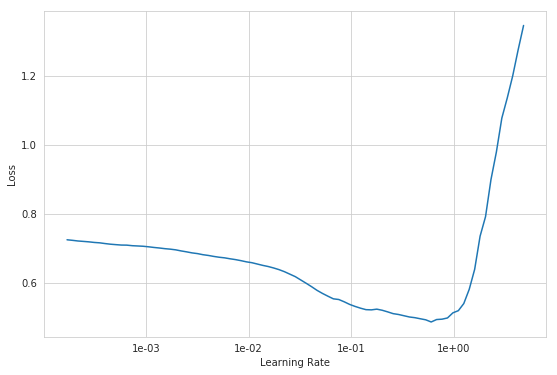

In [43]:
learn.lr_find(lr/1000, wd=wd)
learn.recorder.plot()

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [44]:
%%time
learn.fit_one_cycle(1, lr, wd=wd)

epoch,train_loss,valid_loss,opt_th,fscore,multilbl_accuracy,time
0,0.277101,0.222965,0.222360,0.630812,0.852692,00:09


Better model found at epoch 0 with fscore value: 0.630811870098114.
CPU times: user 6.19 s, sys: 3.08 s, total: 9.27 s
Wall time: 9.4 s


In [45]:
learn.save(f'{m_pre}cls_last_ft{m_suf}')

In [46]:
# will load the best when training ends automaticall ... #learn = learn.load(f'{lm_pre}cls_last_ft{exp_suffix}')

In [47]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,opt_th,fscore,multilbl_accuracy,time
0,0.213559,0.160273,0.213599,0.740178,0.916021,00:10


Better model found at epoch 0 with fscore value: 0.7401776909828186.


In [48]:
learn.save(f'{m_pre}cls_last2_ft{m_suf}')

In [49]:
# will load the best when training ends automaticall ... #learn = learn.load(f'{lm_pre}cls_last2_ft{exp_suffix}')

In [50]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,opt_th,fscore,multilbl_accuracy,time
0,0.168466,0.143895,0.208378,0.757810,0.925701,00:15


Better model found at epoch 0 with fscore value: 0.7578101754188538.


In [51]:
learn.save(f'{m_pre}cls_last3_ft{m_suf}')

In [52]:
# will load the best when training ends automaticall ... 
# learn = learn.load(f'{lm_pre}cls_last3_ft{exp_suffix}')

In [53]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,opt_th,fscore,multilbl_accuracy,time
0,0.162505,0.142740,0.202006,0.763741,0.931139,00:19
1,0.145906,0.140015,0.194395,0.781621,0.935564,00:19
2,0.124353,0.143170,0.209528,0.772963,0.932891,00:19
3,0.105597,0.146575,0.180796,0.778965,0.935103,00:17
4,0.089817,0.151331,0.185900,0.783519,0.938330,00:20


Better model found at epoch 0 with fscore value: 0.7637413740158081.
Better model found at epoch 1 with fscore value: 0.7816213369369507.
Better model found at epoch 4 with fscore value: 0.783519446849823.


In [54]:
learn.save(f'{m_pre}cls{m_suf}')

Export model for inference

In [55]:
learn.export(file=f'{m_pre}export_clas{m_suf}.pkl')

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SequentialRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MultiBatchEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AWD_LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for 

Use it for inference

In [56]:
inf_learn = load_learner(SENTIMENT_PATH, file=f'{m_pre}export_clas{m_suf}.pkl')

In [57]:
inf_learn.data.single_ds.y.classes = SENT_LABELS[1:]

In [58]:
inf_learn.predict('I feel very uncomfortable talking to my supervisor even though she loves dogs. Help!!!')

(MultiCategory is_negative;feels_threatened,
 tensor([0., 0., 0., 1., 0., 1., 0., 0.]),
 tensor([1.4730e-03, 1.6266e-01, 1.2021e-02, 6.5492e-01, 5.8328e-02, 8.6366e-01,
         6.6662e-04, 1.7934e-01]))

Review final validation loss for best model

In [59]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(DatasetType.Valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
print(f'Validation Loss (per label): {loss.mean(dim=0)}')

Validation Loss: 0.15133094787597656
Validation Loss (per label): tensor([0.1484, 0.1853, 0.1463, 0.3093, 0.2455, 0.0665, 0.0138, 0.0955])


In [60]:
print(SENT_LABELS[1:])

['is_very_positive', 'is_positive', 'is_very_negative', 'is_negative', 'is_suggestion', 'feels_threatened', 'has_profanity', 'is_nonsense']


In [61]:
learn.predict("I feel very unsafe and threatened here. I HATE my life!!!")

(MultiCategory is_negative;feels_threatened,
 tensor([0., 0., 0., 1., 0., 1., 0., 0.]),
 tensor([1.8595e-04, 3.9924e-03, 3.9525e-01, 9.8876e-01, 1.9079e-03, 8.2098e-01,
         1.5572e-04, 8.2185e-04]))

## Save models, csvs, to zip and download (optional)

In [62]:
from IPython.display import FileLink

In [63]:
# !zip -r models.zip {LM_PATH}/models/ {CLS_PATH}/models  -x {LM_PATH}/models/lstm_wt103/\*

# FileLink('models.zip')

In [64]:
# !zip verbatims-csvs.zip {PATH}/verbatims.csv {PATH}/verbatims-entities.csv {PATH}/verbatims-meta.csv

# FileLink('verbatims-csvs.zip')

## Review predictions

### Predict sentiment for our validation dataset, including the actual document

In [65]:
# predictions for a single model using the learner's model and data loaders
learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
probs, targs, docs = get_cls_predictions(learn, DatasetType.Valid, vocab)

probs.shape, targs.shape, len(docs)

(torch.Size([1356, 8]), torch.Size([1356, 8]), 1356)

In [66]:
data_clas.valid_ds.y.items.shape, data_clas.valid_ds.y.c, data_clas.valid_ds.y.classes

((1356,),
 8,
 ['is_very_positive',
  'is_positive',
  'is_very_negative',
  'is_negative',
  'is_suggestion',
  'feels_threatened',
  'has_profanity',
  'is_nonsense'])

In [67]:
# determine optimal threshold based on desired f-score
threshold_f05 = metrics_util.best_fthresh(probs, targs, beta=0.5, start=0.1, end=.3).item()
threshold_f1 = metrics_util.best_fthresh(probs, targs, beta=1, start=0.1, end=.3).item()
threshold_f2 = metrics_util.best_fthresh(probs, targs, beta=2, start=0.1, end=.3).item()

threshold_f05, threshold_f1, threshold_f2

(0.28999999165534973, 0.23000000417232513, 0.10000000149011612)

In [68]:
res = fbeta(probs, targs, thresh=threshold_f1, beta=1, sigmoid=False)
res

tensor(0.7785)

In [69]:
from sklearn import metrics

In [70]:
res = metrics.fbeta_score(targs, (probs > threshold_f1), beta=1, average='samples')
res

/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/wgilliam/anaconda3/envs/tritonlytics-ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


0.7785292878213232

In [71]:
preds = ((probs > threshold_f1).byte() == targs.byte()).float().mean()
preds.item()

0.938974916934967

In [72]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_thresh(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_thresh(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_thresh(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9403576850891113, 0.938974916934967, 0.9245944023132324)

### Review classifier

In [73]:
import sklearn
from sklearn import metrics
print (sklearn.__version__)

0.20.2


In [74]:
probs.shape, targs.shape

(torch.Size([1356, 8]), torch.Size([1356, 8]))

In [75]:
eval_targs = targs.flatten() # targs[:,0]
eval_probs = probs.flatten() # probs[:,0]

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [76]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(metrics.accuracy_score(targs, (probs > threshold_f1)))

0.5958702064896755


In [77]:
print(metrics.accuracy_score(eval_targs, (eval_probs > threshold_f1).float()))

0.9389749262536873


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [78]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 9085


In [79]:
most_freq_class_count / len(eval_targs)

0.8374815634218289

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [80]:
print(metrics.cohen_kappa_score(eval_targs, (eval_probs > threshold_f1).float()))

0.787015096194084


#### Confusion Matrix

Describes the performance of a classification model

In [81]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [82]:
cm = metrics.confusion_matrix(eval_targs, (eval_probs > threshold_f1).float())

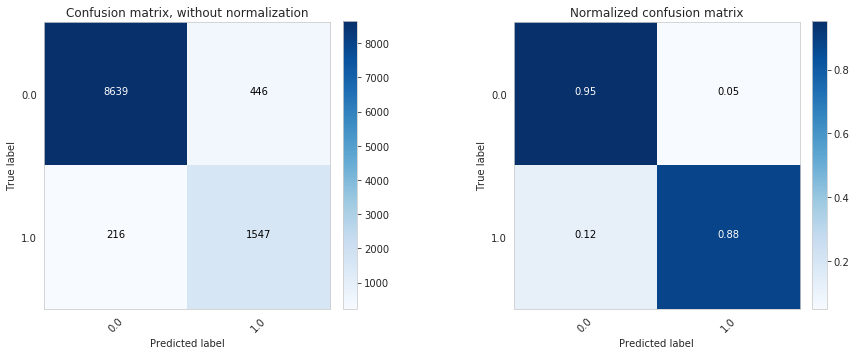

In [83]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [84]:
print(metrics.classification_report(eval_targs, (eval_probs > threshold_f1).float(), [0,1]))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      9085
           1       0.78      0.88      0.82      1763

   micro avg       0.94      0.94      0.94     10848
   macro avg       0.88      0.91      0.89     10848
weighted avg       0.94      0.94      0.94     10848



### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

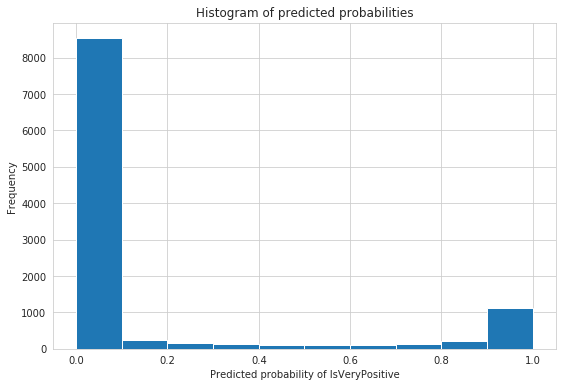

In [85]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of IsVeryPositive')
plt.ylabel('Frequency')

Demonstrates how you can **decrease** the threshold for predicting label in order to **increase the sensitivity** of the classifier

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [86]:
fpr, tpr, thresholds = metrics.roc_curve(eval_targs, eval_probs)

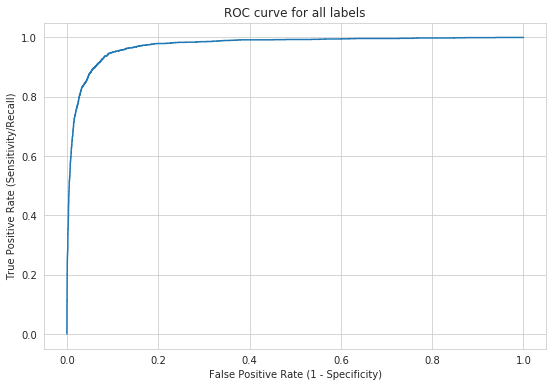

In [87]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [88]:
print(metrics.roc_auc_score(eval_targs, eval_probs))

0.9741767968805363


Let's look at things label by label ...

In [89]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(SENT_LABELS[1:]):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = metrics.roc_auc_score(lbl_targs, lbl_probs)
    
    fpr, tpr, thresholds = metrics.roc_curve(lbl_targs, lbl_probs)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = metrics.accuracy_score(lbl_targs, (lbl_probs > v))
        label_metrics[lbl_name]['cohen_kappas'][k] = metrics.cohen_kappa_score(lbl_targs, (lbl_probs > v))
        label_metrics[lbl_name]['confusion_matrices'][k] = metrics.confusion_matrix(lbl_targs, (lbl_probs > v))
        
        precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(lbl_targs, (lbl_probs > v))
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

IS_VERY_POSITIVE

Null Accuracy:	0.9233038348082596
AUC Score:	0.9484977881543376

		f-beta05(0.29)		f-beta1(0.23)		f-beta2(0.1)
Accuracy:	0.9343657817109144	0.9292035398230089	0.915929203539823	
Cohen's Kappa:	0.582575851907193	0.5718458097618735	0.5723107569721115	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9739              0.9545              0.9641              1252                
1                   0.5581              0.6923              0.618               104                 
avg/total           0.766               0.8234              0.7911              1356                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9761              0.9465              0.9611              1252                
1                   0.5282              0.7212              0.6098              104

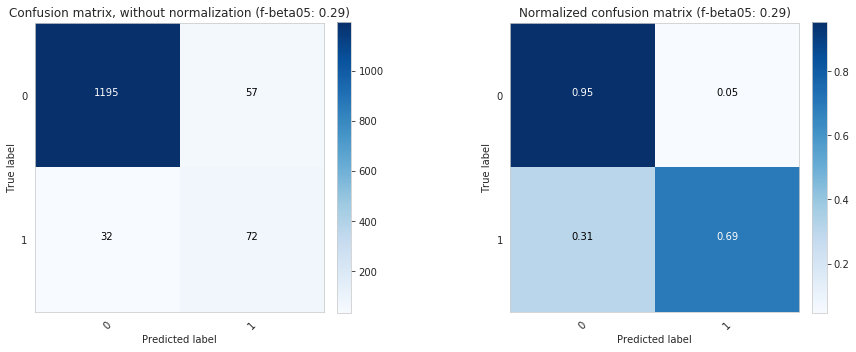

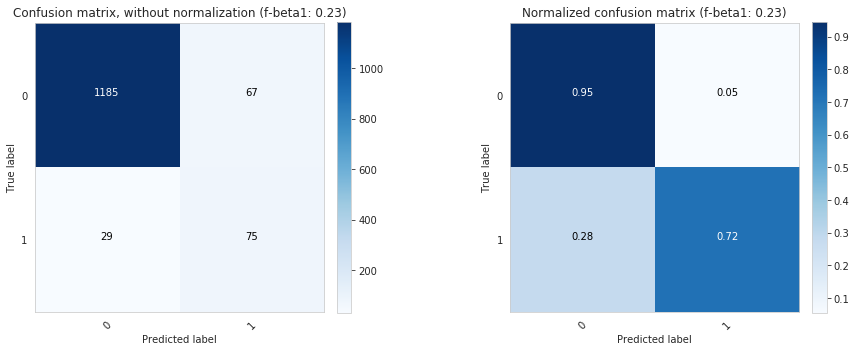

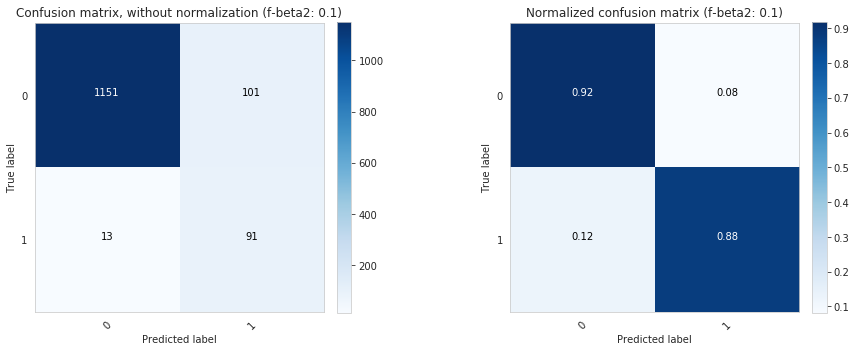



ROC Curve:


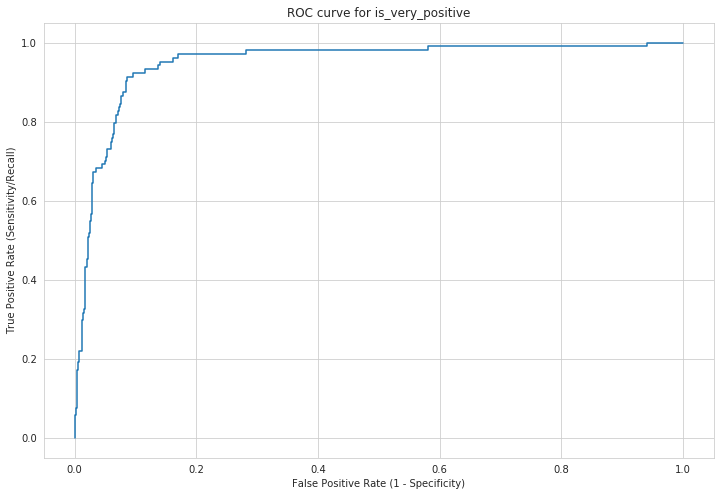

Predicted Probability Distribution:


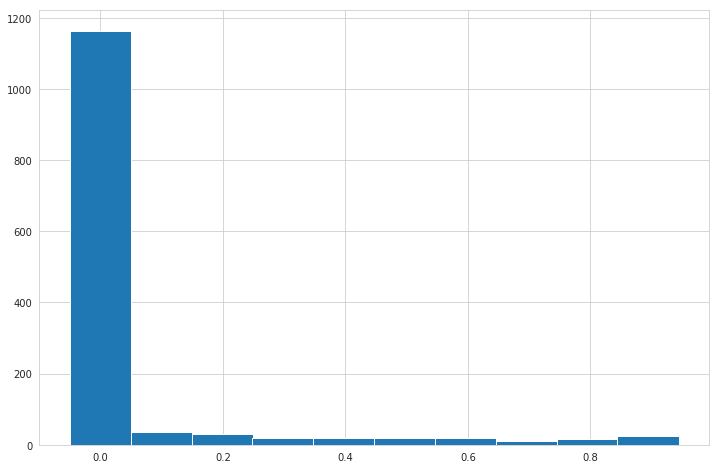



----------------------------------------------------------------------------------------------------


IS_POSITIVE

Null Accuracy:	0.6688790560471977
AUC Score:	0.9781751926982171

		f-beta05(0.29)		f-beta1(0.23)		f-beta2(0.1)
Accuracy:	0.9284660766961652	0.9314159292035398	0.922566371681416	
Cohen's Kappa:	0.8423218010501331	0.8493203716448727	0.8319016202993138	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9688              0.9228              0.9452              907                 
1                   0.8577              0.9399              0.8969              449                 
avg/total           0.9132              0.9313              0.9211              1356                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9744              0.9217              0.9473              907

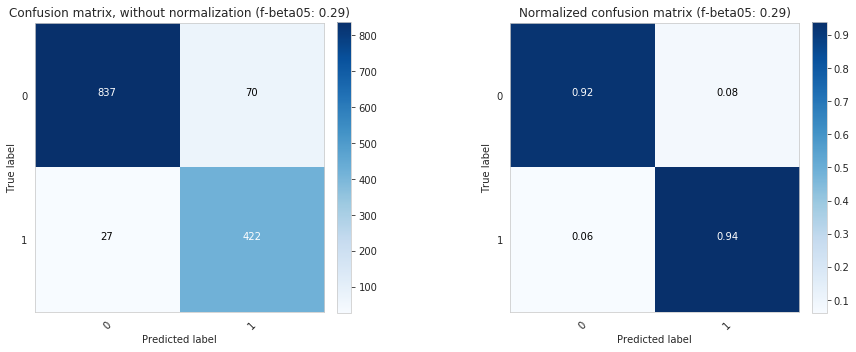

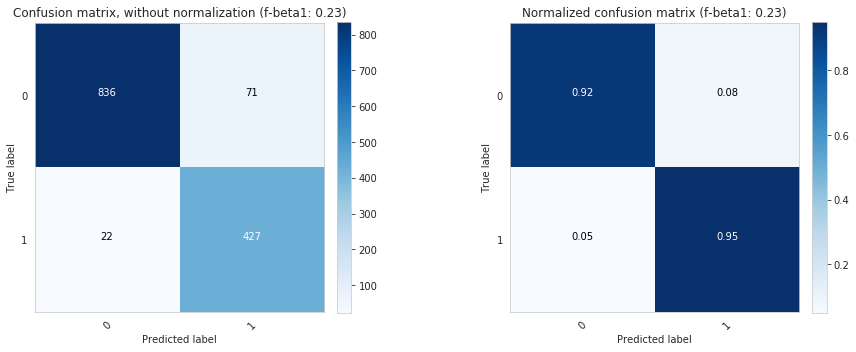

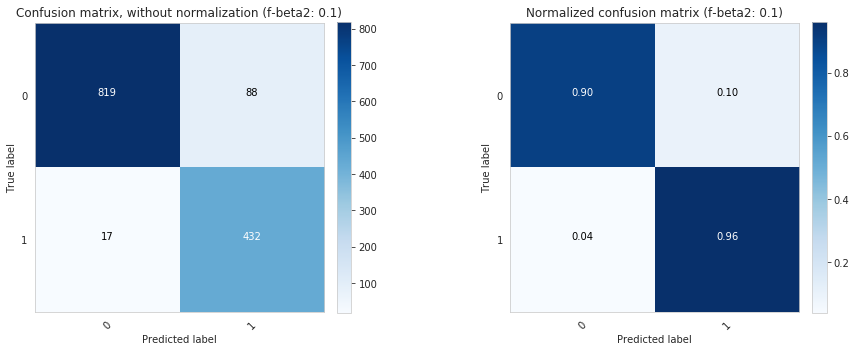



ROC Curve:


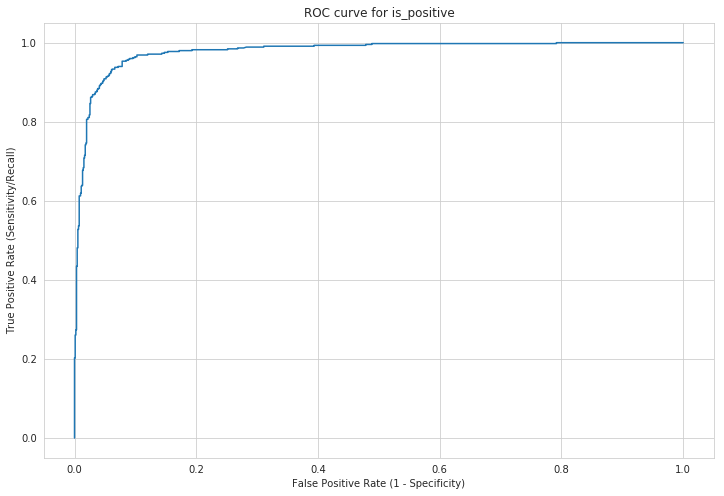

Predicted Probability Distribution:


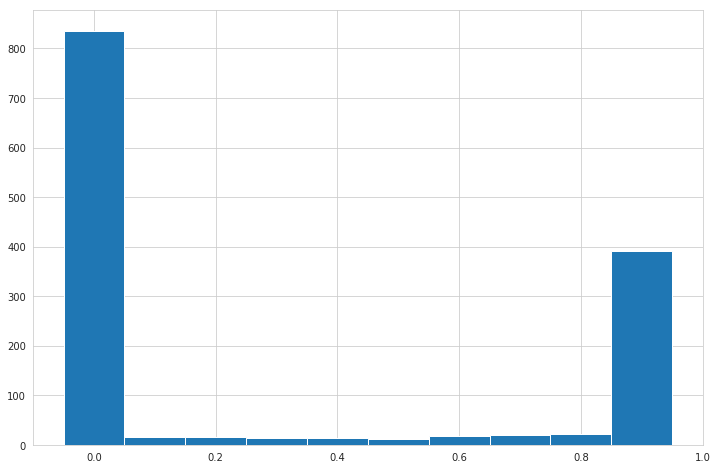



----------------------------------------------------------------------------------------------------


IS_VERY_NEGATIVE

Null Accuracy:	0.918141592920354
AUC Score:	0.9456709721769962

		f-beta05(0.29)		f-beta1(0.23)		f-beta2(0.1)
Accuracy:	0.9284660766961652	0.9240412979351033	0.8989675516224189	
Cohen's Kappa:	0.5482049379662833	0.5643760760535967	0.5329169683804007	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9659              0.9558              0.9608              1245                
1                   0.5565              0.6216              0.5872              111                 
avg/total           0.7612              0.7887              0.774               1356                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9735              0.943               0.958             

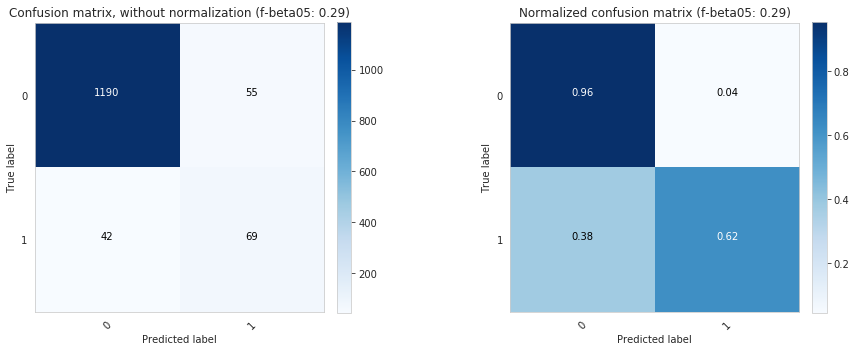

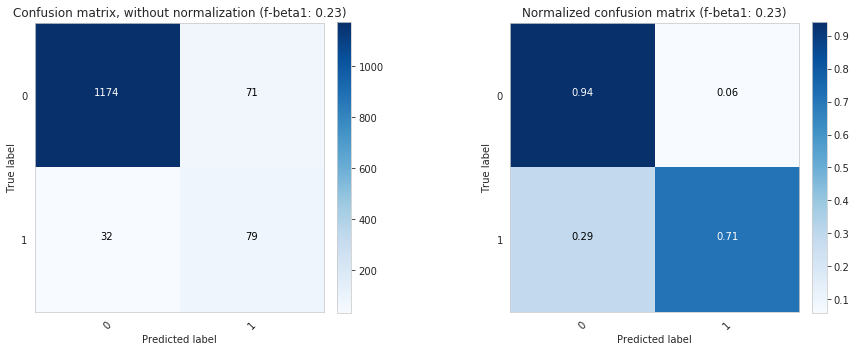

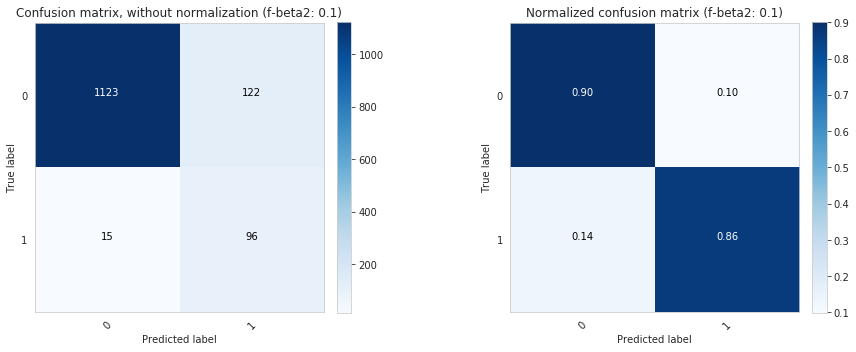



ROC Curve:


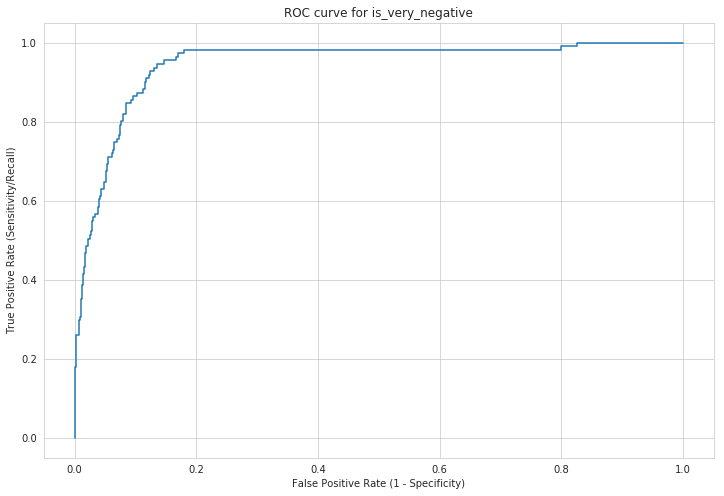

Predicted Probability Distribution:


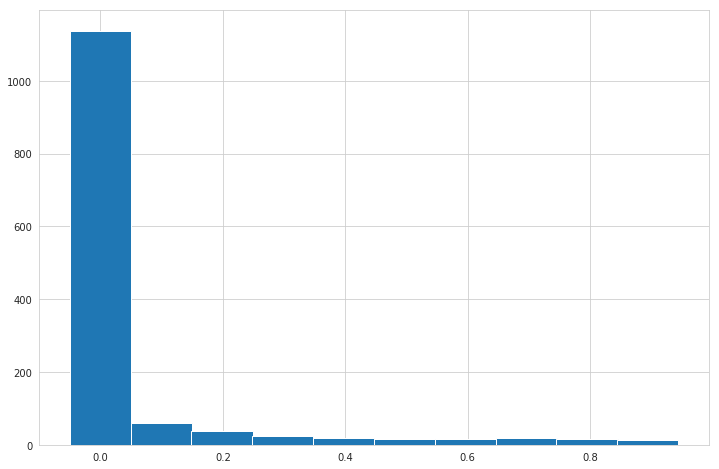



----------------------------------------------------------------------------------------------------


IS_NEGATIVE

Null Accuracy:	0.6275811209439528
AUC Score:	0.9489174064292446

		f-beta05(0.29)		f-beta1(0.23)		f-beta2(0.1)
Accuracy:	0.8864306784660767	0.8842182890855457	0.859882005899705	
Cohen's Kappa:	0.7580170805474119	0.7561385743937027	0.7134002407242195	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9144              0.9036              0.909               851                 
1                   0.8408              0.8574              0.849               505                 
avg/total           0.8776              0.8805              0.879               1356                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9273              0.8848              0.9056              851

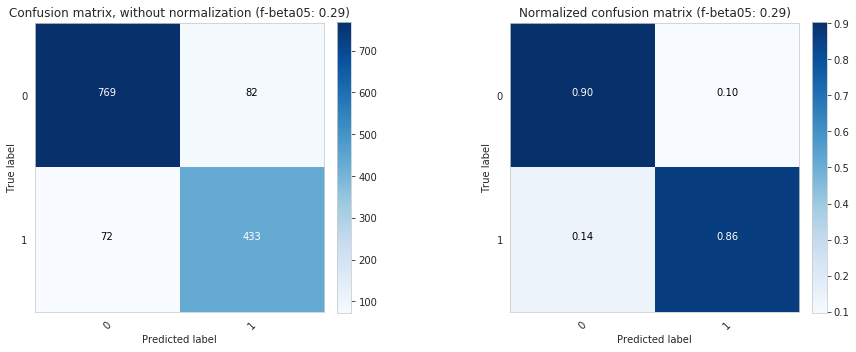

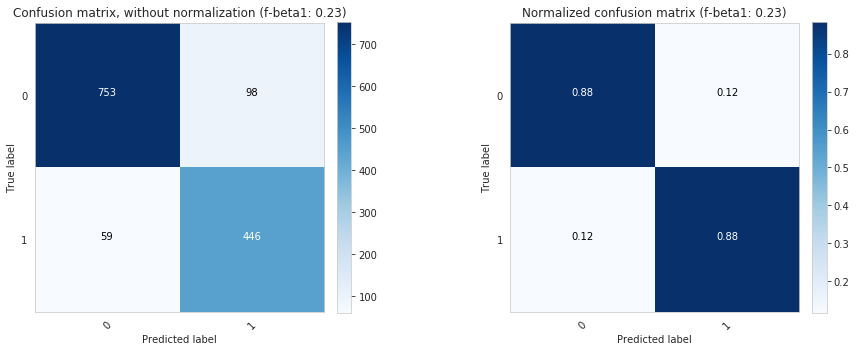

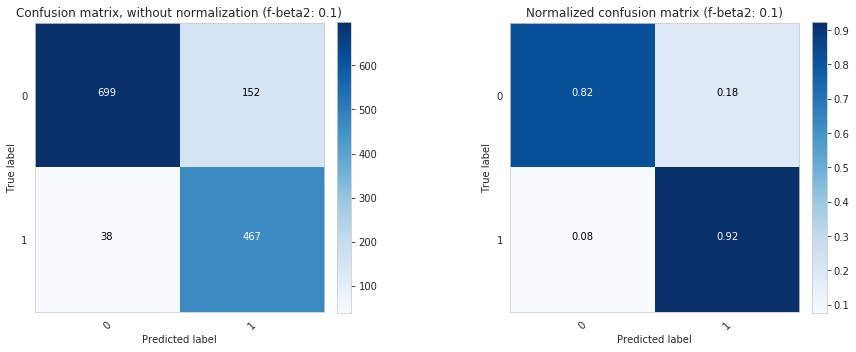



ROC Curve:


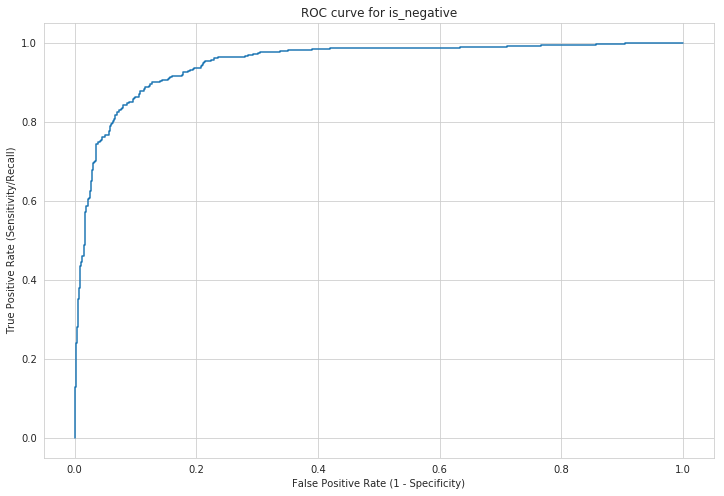

Predicted Probability Distribution:


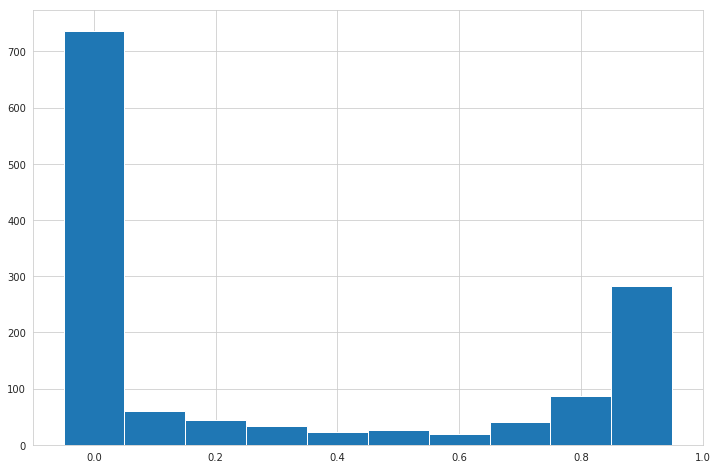



----------------------------------------------------------------------------------------------------


IS_SUGGESTION

Null Accuracy:	0.6784660766961652
AUC Score:	0.9660176505783804

		f-beta05(0.29)		f-beta1(0.23)		f-beta2(0.1)
Accuracy:	0.9092920353982301	0.9100294985250738	0.8967551622418879	
Cohen's Kappa:	0.7946982043416821	0.7976931204508101	0.77425799086758	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9433              0.9217              0.9324              920                 
1                   0.8425              0.883               0.8623              436                 
avg/total           0.8929              0.9024              0.8973              1356                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9493              0.9163              0.9325              92

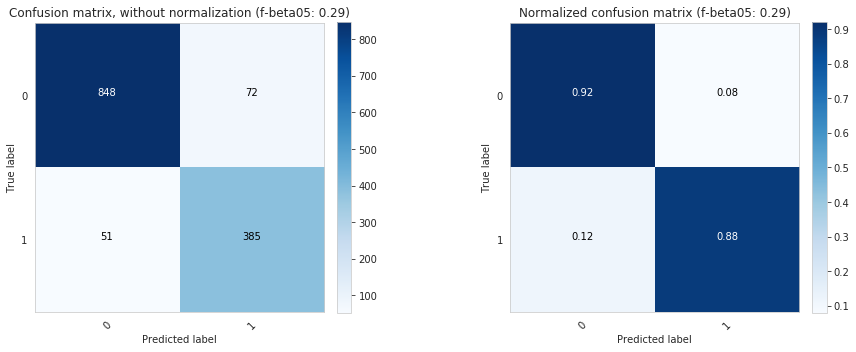

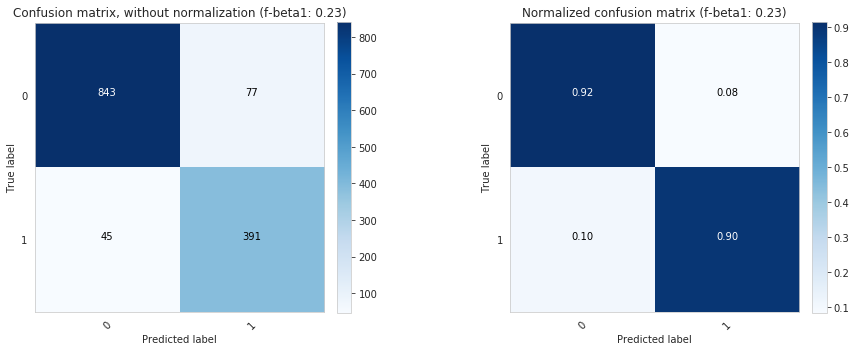

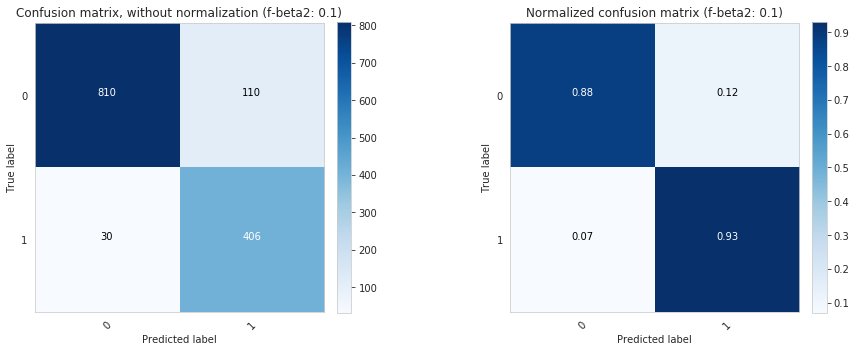



ROC Curve:


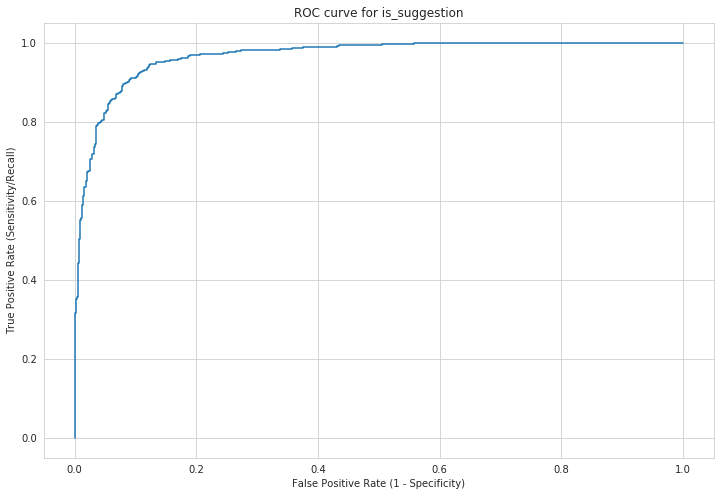

Predicted Probability Distribution:


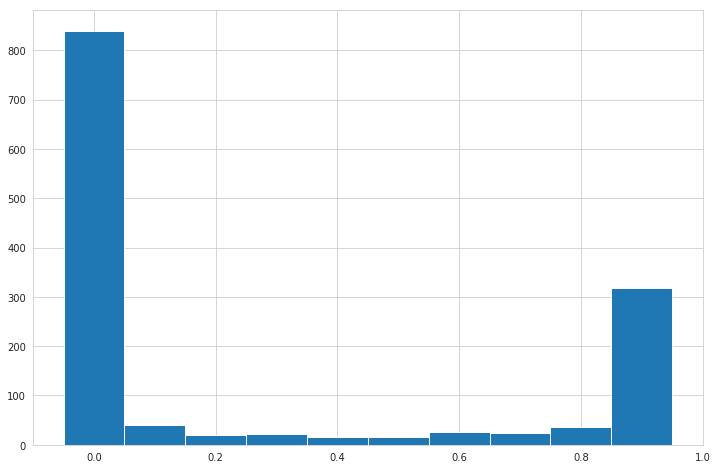



----------------------------------------------------------------------------------------------------


FEELS_THREATENED

Null Accuracy:	0.9660766961651918
AUC Score:	0.9795884500497842

		f-beta05(0.29)		f-beta1(0.23)		f-beta2(0.1)
Accuracy:	0.9778761061946902	0.9771386430678466	0.971976401179941	
Cohen's Kappa:	0.6552308631093633	0.6548315049596006	0.6271922208716791	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9878              0.9893              0.9886              1310                
1                   0.6818              0.6522              0.6667              46                  
avg/total           0.8348              0.8207              0.8276              1356                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9885              0.9878              0.9882            

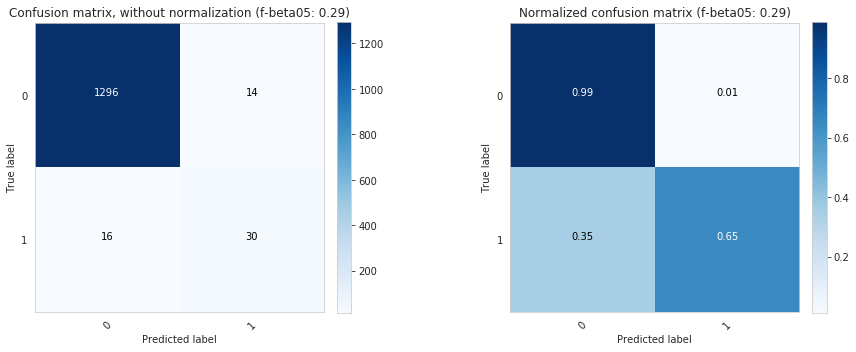

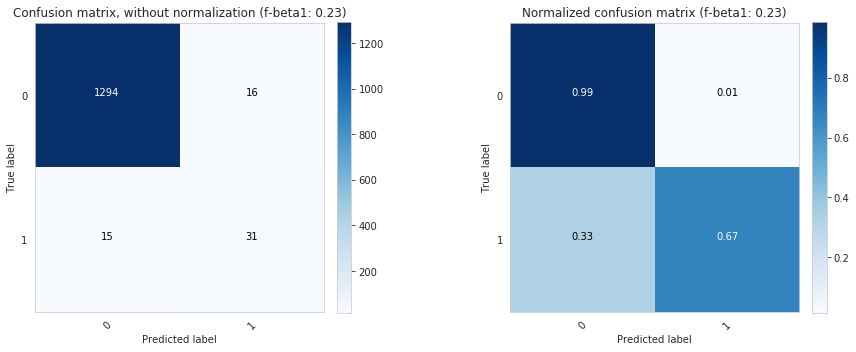

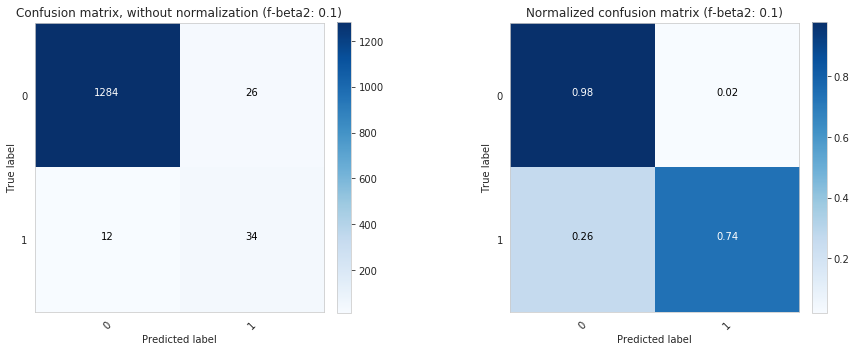



ROC Curve:


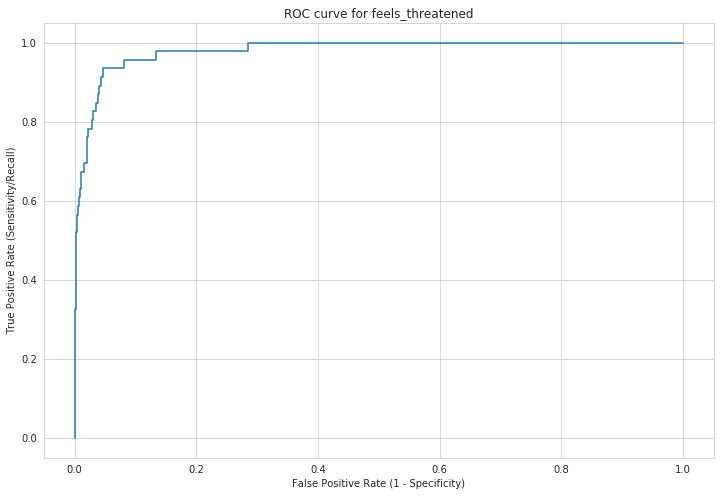

Predicted Probability Distribution:


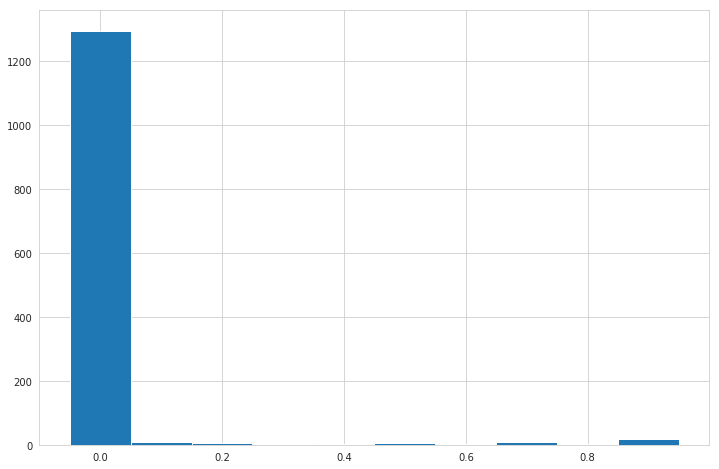



----------------------------------------------------------------------------------------------------


HAS_PROFANITY

Null Accuracy:	0.9874631268436578
AUC Score:	0.9972762816851908

		f-beta05(0.29)		f-beta1(0.23)		f-beta2(0.1)
Accuracy:	0.9941002949852508	0.9941002949852508	0.9933628318584071	
Cohen's Kappa:	0.7617185783947634	0.7617185783947634	0.7659199017953046	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.997               0.997               0.997               1339                
1                   0.7647              0.7647              0.7647              17                  
avg/total           0.8809              0.8809              0.8809              1356                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.997               0.997               0.997               

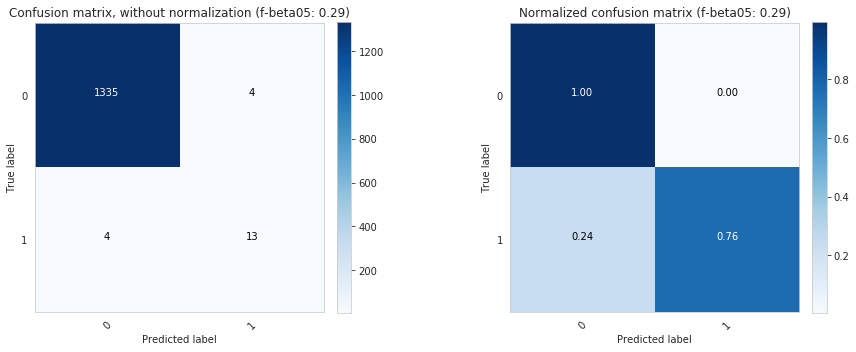

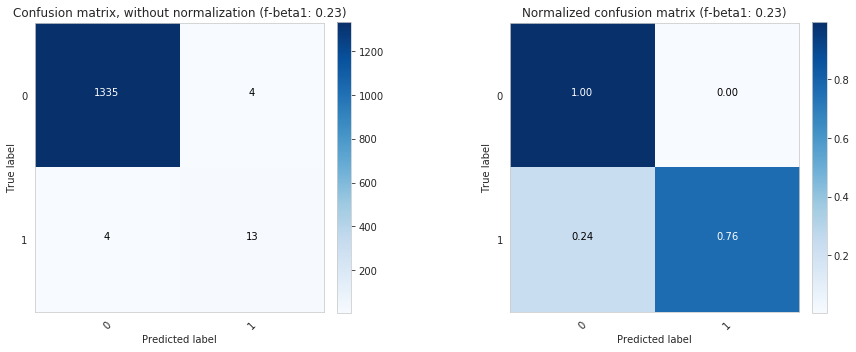

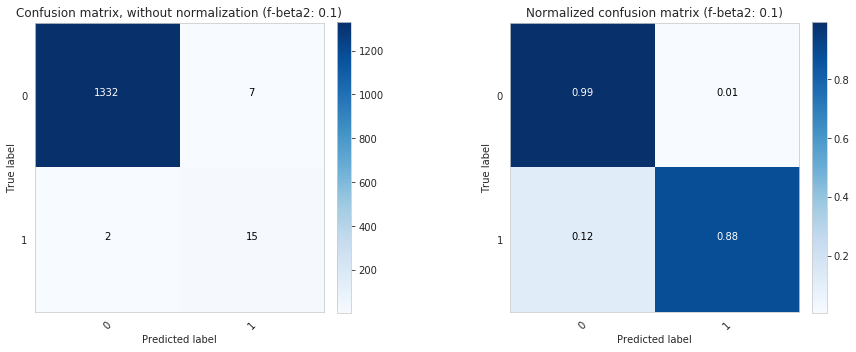



ROC Curve:


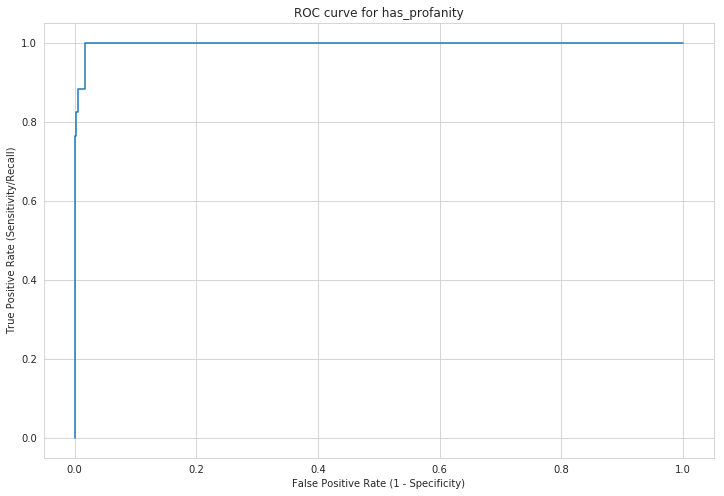

Predicted Probability Distribution:


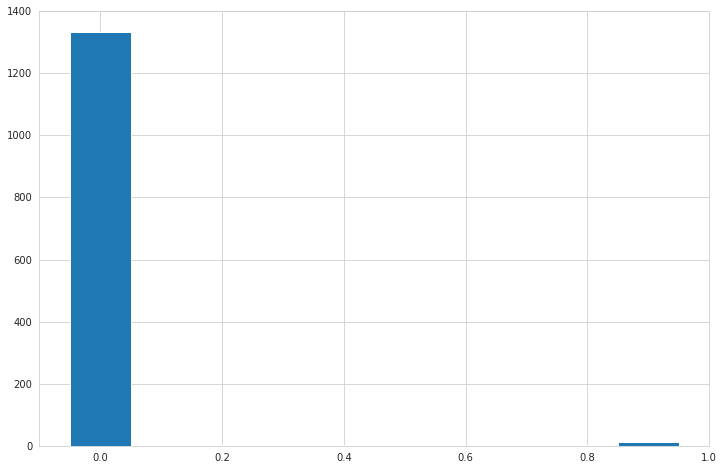



----------------------------------------------------------------------------------------------------


IS_NONSENSE

Null Accuracy:	0.9299410029498525
AUC Score:	0.9665303226345007

		f-beta05(0.29)		f-beta1(0.23)		f-beta2(0.1)
Accuracy:	0.9638643067846607	0.9616519174041298	0.9373156342182891	
Cohen's Kappa:	0.7548843111793176	0.7453539519396755	0.6398620189723913	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9911              0.9699              0.9804              1261                
1                   0.6885              0.8842              0.7742              95                  
avg/total           0.8398              0.927               0.8773              1356                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9919              0.9667              0.9791              12

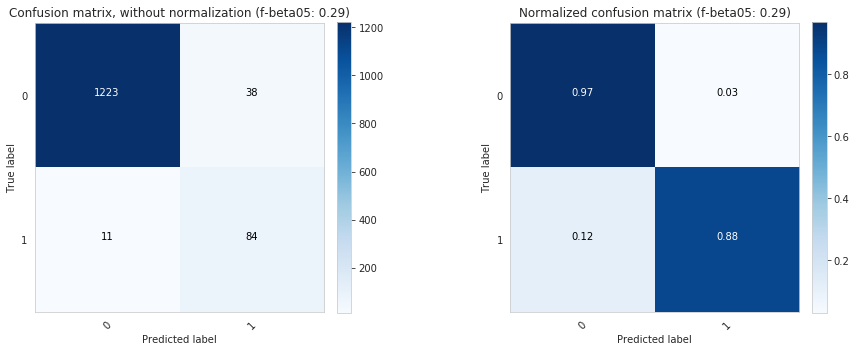

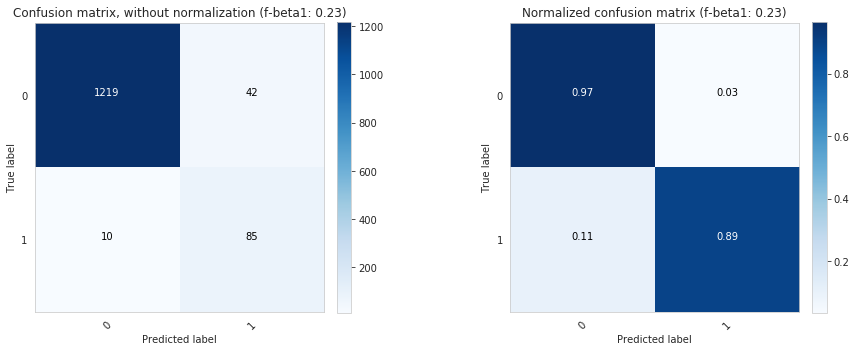

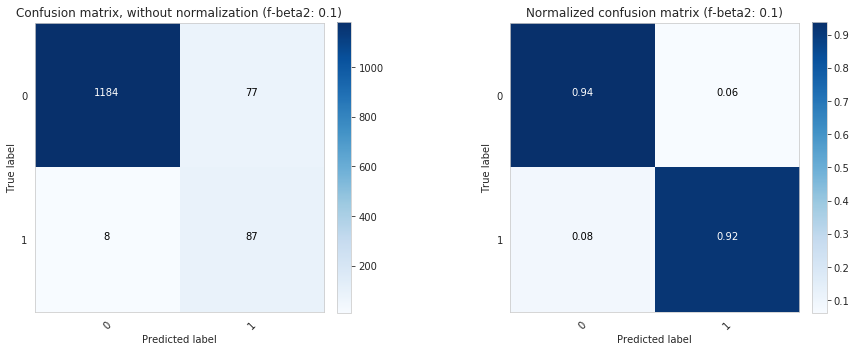



ROC Curve:


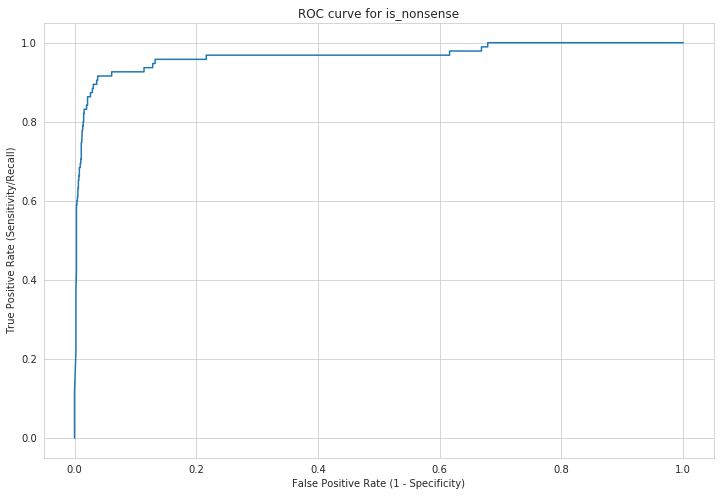

Predicted Probability Distribution:


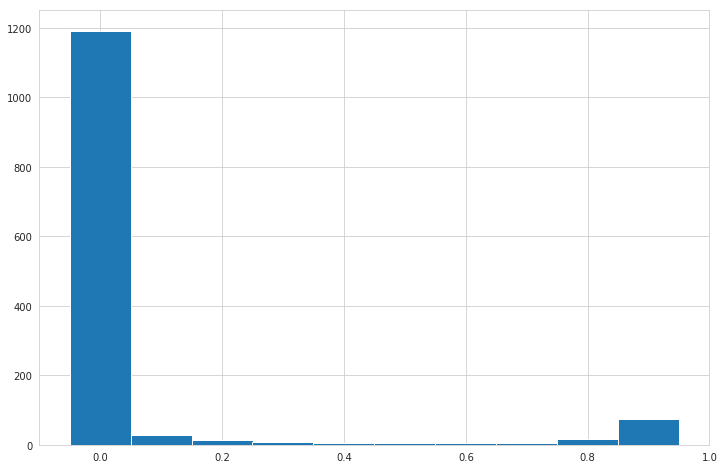



----------------------------------------------------------------------------------------------------




In [90]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

### Ensemble forwards and backwards passes

In [91]:
try:
    learn_fwd.purge(); learn = None;
    learn_bwd.purge(); learn_bwd = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass


bsz = 80
m_suf = '_multilabel'

learn_fwd = load_learner(SENTIMENT_PATH, file=f'fwd_export_clas{m_suf}.pkl')
data_fwd = load_data(SENTIMENT_PATH, f'data_cls_sentiment.pkl', bs=bsz)
learn_fwd.data = data_fwd

learn_bwd = load_learner(SENTIMENT_PATH, file=f'bwd_export_clas{m_suf}.pkl')
data_bwd = load_data(SENTIMENT_PATH, f'data_cls_sentiment.pkl', bs=bsz, backwards=True)
learn_bwd.data = data_bwd

In [92]:
probs_fwd, lbl_fwd, loss_fwd = learn_fwd.get_preds(ordered=True, with_loss=True)
probs_bwd, lbl_bwd, loss_bwd = learn_bwd.get_preds(ordered=True, with_loss=True)

probs_fwd.shape, probs_bwd.shape, loss_fwd.shape

(torch.Size([1356, 8]), torch.Size([1356, 8]), torch.Size([1356, 8]))

In [93]:
loss_fwd.mean(), probs_bwd.mean(), (loss_fwd.mean() + probs_bwd.mean()) / 2

(tensor(0.1353), tensor(0.1583), tensor(0.1468))

In [94]:
probs_final = (probs_fwd + probs_bwd) / 2

#### Results

In [95]:
# determine optimal threshold based on desired f-score
threshold_f05 = metrics_util.best_fthresh(probs_fwd, lbl_fwd, beta=0.5, start=0.1, end=.3).item()
threshold_f1 = metrics_util.best_fthresh(probs_fwd, lbl_fwd, beta=1, start=0.1, end=.3).item()
threshold_f2 = metrics_util.best_fthresh(probs_fwd, lbl_fwd, beta=2, start=0.1, end=.3).item()

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_thresh(probs_fwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_thresh(probs_fwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_thresh(probs_fwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_thresh(probs_fwd, lbl_fwd, sigmoid=False)}')

Fowards Only
-------------
f05:	Optimal threshold = 0.28999999165534973	(Accuracy = 0.9412794709205627)
f1:	Optimal threshold = 0.27000001072883606		(Accuracy = 0.9408186078071594)
f2:	Optimal threshold = 0.15000000596046448	(Accuracy = 0.924963116645813)

Accuracy: 0.9437684416770935


In [96]:
# determine optimal threshold based on desired f-score
threshold_f05 = metrics_util.best_fthresh(probs_bwd, lbl_fwd, beta=0.5, start=0.1, end=.3).item()
threshold_f1 = metrics_util.best_fthresh(probs_bwd, lbl_fwd, beta=1, start=0.1, end=.3).item()
threshold_f2 = metrics_util.best_fthresh(probs_bwd, lbl_fwd, beta=2, start=0.1, end=.3).item()

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_thresh(probs_bwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_thresh(probs_bwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_thresh(probs_bwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Backwards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05} (Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1} (Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2} (Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_thresh(probs_bwd, lbl_fwd, sigmoid=False)}')

Backwards Only
-------------
f05:	Optimal threshold = 0.28999999165534973 (Accuracy = 0.9403576850891113)
f1:	Optimal threshold = 0.23000000417232513 (Accuracy = 0.938974916934967)
f2:	Optimal threshold = 0.10000000149011612 (Accuracy = 0.9245944023132324)

Accuracy: 0.9449667930603027


In [97]:
# determine optimal threshold based on desired f-score
threshold_f05 = metrics_util.best_fthresh(probs_final, lbl_fwd, beta=0.5, start=0.1, end=.3).item()
threshold_f1 = metrics_util.best_fthresh(probs_final, lbl_fwd, beta=1, start=0.1, end=.3).item()
threshold_f2 = metrics_util.best_fthresh(probs_final, lbl_fwd, beta=2, start=0.1, end=.3).item()

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_thresh(probs_final, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_thresh(probs_final, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_thresh(probs_final, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Ensemble\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05} (Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1} (Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2} (Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_thresh(probs_final, lbl_fwd, sigmoid=False)}')

Ensemble
-------------
f05:	Optimal threshold = 0.28999999165534973 (Accuracy = 0.9430309534072876)
f1:	Optimal threshold = 0.28999999165534973 (Accuracy = 0.9430309534072876)
f2:	Optimal threshold = 0.17000000178813934 (Accuracy = 0.9334439635276794)

Accuracy: 0.9472714066505432


In [ ]:
final_valid_loss = (loss_fwd.mean() + probs_bwd.mean()) / 2

### Inference (ad-hoc documents)

In [98]:
print(SENT_LABELS[1:])

['is_very_positive', 'is_positive', 'is_very_negative', 'is_negative', 'is_suggestion', 'feels_threatened', 'has_profanity', 'is_nonsense']


In [105]:
test_comments = [
    'The parking situation REALLY sucks around here.  It needs to be fixed',
    'I LOVE working at UCSD!!!  It is wonderful',
    """Some staff are just uninformed.There is no support for solo-individual study (no closed off rooms).
        Once a guy (quite tall) walked in into the girl's restroom and used the stalls standing up. 
        There was no line in the guy's restroom. This happened when I done and was going to walk out. 
        I was extremely uncomfortable""",
    "I love UCSD!!! It is a terrible place to work!",
    "I was really uncomfortable to express my opinion!!!"
]

doc_probs, doc_preds, doc_toks = get_cls_doc_predictions(learn.model, vocab, tokenizer, test_comments, 
                                                         threshold=threshold_f1)

In [106]:
len(doc_probs), len(doc_probs), len(doc_toks)

(5, 5, 5)

In [107]:
for d_probs, d_preds, d_toks in zip(doc_probs, doc_preds, doc_toks):
    print(f'> {" ".join([t for t in d_toks])}\nProbabilities:\t{d_probs}\nPredictions:\t{d_preds}\n')

> xxmaj the parking situation xxup really sucks around here . xxmaj it needs to be fixed
Probabilities:	tensor([[3.2204e-04, 9.8032e-04, 2.8493e-01, 9.4551e-01, 5.9507e-01, 3.8121e-04,
         8.0752e-02, 1.6670e-02]])
Predictions:	tensor([0., 0., 0., 1., 1., 0., 0., 0.])

> i xxup love working at xxup ucsd ! ! ! xxmaj it is wonderful
Probabilities:	tensor([[7.8272e-01, 9.9947e-01, 2.9631e-05, 4.6623e-05, 1.5644e-03, 7.3575e-06,
         1.1150e-05, 1.5863e-04]])
Predictions:	tensor([1., 1., 0., 0., 0., 0., 0., 0.])

> xxmaj some staff are just uninformed . xxmaj there   is no support for solo - individual study ( no closed off rooms ) . 
  xxmaj once a guy ( quite tall ) walked in into the girl 's restroom and used the stalls standing up . 
  xxmaj there was no line in the guy 's restroom . xxmaj this happened when i done and was going to walk out . 
  i was extremely uncomfortable
Probabilities:	tensor([[9.8856e-05, 2.7718e-03, 1.0648e-04, 1.5832e-02, 5.3188e-03, 9.1866e-05,
       

### Inference (batch ensemble)

In [108]:
import datetime
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

m_suf = '_multilabel'

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:1


In [109]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**lm_dtypes}, parse_dates=[])

inf_df = verbatims_df.copy() #verbatims_df[test_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df))

corpus_cols = ['AnswerText']  # ['question_text', 'answer_text']

591447


In [110]:
def concat_pool(raw_outputs):
    last_rnn_layer = raw_outputs[-1]
    bsz = last_rnn_layer.shape[0] 
    
    avg_pool = F.adaptive_avg_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    max_pool = F.adaptive_max_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    last_outp = last_rnn_layer[:,-1,:]

    return torch.cat([last_outp, max_pool, avg_pool], 1)

In [111]:
def get_sentiment_results(backwards:bool=False, m_suf:str='multilabel'):
    
    model_prefix = 'bwd' if backwards else 'fwd'
    
    # 1. grab learner, procs, and data
    inf_learn = load_learner(SENTIMENT_PATH, file=f'{model_prefix}_export_clas_{m_suf}.pkl')
    txt_procs = inf_learn.data.train_ds.processor
    inf_data = TextList.from_df(inf_df, cols=corpus_cols, processor=txt_procs).split_none().label_empty()
    
    # 2. define a suitable dataloader
    collate_fn = partial(pad_collate, pad_first=True, backwards=backwards)
    sampler = SortSampler(inf_data.train.x, key=[len(t) for t in inf_data.train.x.items].__getitem__)
    dl = DeviceDataLoader.create(inf_data.train, bs=128, sampler=sampler, collate_fn=collate_fn, device=device)
    
    # 3. get probs and document vectors
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    test_probs, doc_vecs, concat_doc_vecs = [], [], []
    with torch.no_grad():
        for index, (xb, yb) in enumerate(dl):
            if index % 1000 == 0:  print(index)

            # reset hidden state (if you don't do this you will OOM)
            inf_learn.model.reset()

            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            probs, raw_outputs, outputs = inf_learn.model(xb)

            test_probs.append(to_detach(probs))
            doc_vecs.append(to_detach(raw_outputs[-1][:,-1,:]))
            concat_doc_vecs.append(to_detach(concat_pool(raw_outputs)))

    all_probs = torch.cat(test_probs)
    all_vecs = torch.cat(doc_vecs)
    all_concat_vecs = torch.cat(concat_doc_vecs)

    # 4. ensure results are returned in order
    if hasattr(dl, 'sampler'):
        sampler_idxs = [i for i in dl.sampler]
        reverse_sampler = np.argsort(sampler_idxs)

        all_probs = all_probs[reverse_sampler]
        all_vecs = all_vecs[reverse_sampler]
        all_concat_vecs = all_concat_vecs[reverse_sampler]
        
    # 5. return ordered results
    inf_learn, inf_data = None, None; gc.collect()
    
    return all_probs, all_vecs, all_concat_vecs

In [112]:
%time

probs_fwd, vecs_fwd, concat_vecs_fwd = get_sentiment_results(backwards=False)
probs_bwd, vecs_bwd, concat_vecs_bwd = get_sentiment_results(backwards=True)

probs_final = (probs_fwd + probs_bwd) / 2

print(probs_final.shape)
print(probs_fwd.shape, vecs_fwd.shape, concat_vecs_fwd.shape)
print(probs_bwd.shape, vecs_bwd.shape, concat_vecs_bwd.shape)

0
1000
2000
3000
4000
torch.Size([591447, 8])
torch.Size([591447, 8]) torch.Size([591447, 400]) torch.Size([591447, 1200])
torch.Size([591447, 8]) torch.Size([591447, 400]) torch.Size([591447, 1200])


Add the probabilities of each label to `inf_df`

In [113]:
prob_labels = ['prob_' + lbl for lbl in SENT_LABELS[1:]]
probs_df = pd.DataFrame(probs_final.numpy(), columns=prob_labels)
probs_df.head()

,prob_is_very_positive,prob_is_positive,prob_is_very_negative,prob_is_negative,prob_is_suggestion,prob_feels_threatened,prob_has_profanity,prob_is_nonsense
0,0.000305,0.001720,0.000751,0.112513,0.994707,0.000100,0.000077,0.001805
1,0.000020,0.000154,0.742356,0.999796,0.000258,0.000027,0.000445,0.000043
2,0.000586,0.001099,0.000269,0.023005,0.996164,0.000281,0.000055,0.006396
3,0.007643,0.689901,0.001430,0.007933,0.135764,0.000422,0.000528,0.012663
4,0.000274,0.040167,0.019046,0.573298,0.000499,0.000450,0.001083,0.157921


In [114]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f1 threshold

In [115]:
for lbl in SENT_LABELS[1:]:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f1).astype(np.int64)

Include found thresholds

In [116]:
final_df['threshold_f05'] = threshold_f05
final_df['threshold_f1'] = threshold_f1
final_df['threshold_f2'] = threshold_f2

final_df['val_acc_f05'] = val_acc_f05
final_df['val_acc_f1'] = val_acc_f1
final_df['val_acc_f2'] = val_acc_f2

final_df['val_loss'] = final_valid_loss

In [117]:
final_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,prob_is_very_positive,prob_is_positive,prob_is_very_negative,prob_is_negative,prob_is_suggestion,prob_feels_threatened,prob_has_profanity,prob_is_nonsense,pred_is_very_positive,pred_is_positive,pred_is_very_negative,pred_is_negative,pred_is_suggestion,pred_feels_threatened,pred_has_profanity,pred_is_nonsense,threshold_f05,threshold_f1,threshold_f2
0,292619,8478,Perhaps a more detailed and clear instruction would help first time users,NaN,English,94,7,CSS-STUDENT-ONLY,UCSD,153408,Print,Let us know your suggestions on how to improve Print & Copy Centers/Imprints Copy Centers,Verbatim-Dept-Improve,12.0,Imprints-Improve,Print & Copy Centers/imprints Copy Centers,Auxiliary Services,Imprints & Copy,Imprints & Copy,1,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000305,0.001720,0.000751,0.112513,0.994707,0.000100,0.000077,0.001805,0,0,0,0,1,0,0,0,0.29,0.29,0.17
1,569980,85109,Too expensive,NaN,English,207,39,CSS-STUDENT-ONLY,UCD,426209,UC Davis Stores,Please provide any reasons for <u>not</u> using the TechHub Repair Services.,Verbatim-Dept-Question,1010.0,UC Davis Stores_Reasons,UC Davis Stores,Auxiliary Services,"Dining, Catering, & Retail Services",Bookstore,3,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000020,0.000154,0.742356,0.999796,0.000258,0.000027,0.000445,0.000043,0,0,1,1,0,0,0,0,0.29,0.29,0.17
2,204531,34705,Possibly adding more areas to eat and providing student discounts.,NaN,English,138,29,CSS,CSUF,220671,Campus Dining Services,How do you think Campus Dining Services can improve?,Verbatim-Dept-Improve,494.0,CampusDining_Improve,"Campus Dining (Starbucks, Hibachi-San, Pieology, Carl's Jr, etc. Not the Gastronome)",Auxiliary Services,"Dining, Catering, & Retail Services",Dining Services,1,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000586,0.001099,0.000269,0.023005,0.996164,0.000281,0.000055,0.006396,0,0,0,0,1,0,0,0,0.29,0.29,0.17
3,317152,12746,The affordability of rec classes,NaN,English,130,15,CSS-FACULTY-STAFF-ONLY,UCSD,186262,Recreation,Let us know what you like best about Recreation,Verbatim-Dept-Question,168.0,Recreation_Like-2,Recreation,Student,Sports & Recreation,Recreation,1,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007643,0.689901,0.001430,0.007933,0.135764,0.000422,0.000528,0.012663,0,1,0,0,0,0,0,0,0.29,0.29,0.17
4,7005,1893,"I don't live on campus, but from what I've heard nothing ever seems to get anywhere properly.",NaN,English,25,7,CSS-STUDENT-ONLY,UCSD,78170,Stud Mail,Any additional comments for STUDENT MAIL SERVICES?,Verbatim-Dept-Question,8.0,MailServices-Comments,Student Mail Services,Logistics Services,Logistics Support Services,Mail Services,1,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000274,0.040167,0.019046,0.573298,0.000499,0.000450,0.001083,0.157921,0,0,0,1,0,0,0,0,0.29,0.29,0.17


In [118]:
import datetime
final_df.to_csv(SENTIMENT_PATH/f'{yyyymmdd}_ensemble_predictions{m_suf}.csv', index=False)

### Save document vectors

In [119]:
%time 

np.save(SENTIMENT_PATH/f'{yyyymmdd}_fwd_concat_docvecs_d400{m_suf}.npy', concat_vecs_fwd.numpy())  
np.save(SENTIMENT_PATH/f'{yyyymmdd}_fwd_docvecs_d400{m_suf}.npy', vecs_fwd.numpy())

np.save(SENTIMENT_PATH/f'{yyyymmdd}_bwd_concat_docvecs_d400{m_suf}.npy', concat_vecs_bwd.numpy())  
np.save(SENTIMENT_PATH/f'{yyyymmdd}_bwd_docvecs_d400{m_suf}.npy', vecs_bwd.numpy())

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 16 µs


### Playground

In [120]:
type(threshold_f05)

float

In [121]:
threat_df = final_df[final_df.prob_feels_threatened > threshold_f2]
# threat_df = final_df[(final_df.FeelsThreatened == 1) & (pd.notna(final_df.LastTaggedOn))]
threat_df

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,prob_is_very_positive,prob_is_positive,prob_is_very_negative,prob_is_negative,prob_is_suggestion,prob_feels_threatened,prob_has_profanity,prob_is_nonsense,pred_is_very_positive,pred_is_positive,pred_is_very_negative,pred_is_negative,pred_is_suggestion,pred_feels_threatened,pred_has_profanity,pred_is_nonsense,threshold_f05,threshold_f1,threshold_f2
72,194619,13199,"When diversity gives special preference or privileges to any group regardless of reason, it crea...",NaN,English,105,18,SAW,UCR,162433,NaN,"Please provide any comments regarding campus equity, diversity, and inclusion:",Verbatim,NaN,Diversity - Comments,NaN,NaN,NaN,NaN,NaN,200044.0,3199,500000.0,Business and Administrative Services,400007.0,Auxiliary Services,300051.0,Business Support Services,200044.0,Printing & Reprographics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000283,0.014089,0.043428,0.931239,0.012961,0.896613,0.000286,0.008641,0,0,0,1,0,1,0,0,0.29,0.29,0.17
92,580422,86399,Upper Management's accessibility to low level employees. Break away from protocol of a hierarchi...,NaN,English,208,40,SAW,CSLA,436798,NaN,What one thing at Cal State LA would you like to see improved?,Verbatim-Dept-Improve,NaN,Process Improvement,NaN,NaN,NaN,NaN,NaN,302600.0,5003,999999.0,CAL STATE LA - STAFF,300000.0,VICE PRESIDENT FOR ADMINISTRATION & CHIEF FINANCIAL OFFICER (VPAF),302000.0,AVP FOR FINANCIAL SERVICES,302600.0,PROCUREMENT CONTRACTS & SUPPORT SERVICES / DISTRIBUTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000990,0.028536,0.025024,0.445204,0.616300,0.176372,0.000742,0.012849,0,0,0,1,1,0,0,0,0.29,0.29,0.17
149,198243,1877,"""My performance is evaluated fairly"" - I wouldn't know if it is or isn't, as I do a self-assess...",NaN,English,123,9,SAW,UCSD,141292,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,NaN,2699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009944,0.075614,0.584771,0.961001,0.033258,0.758909,0.005462,0.001379,0,0,1,1,0,1,0,0,0.29,0.29,0.17
180,472981,19982,"I am a Chicanx student who loves that the staff speaks Spanish to me. However, I do understand h...",NaN,English,198,7,CSS-STUDENT-ONLY,UCSD,382014,RRC,Let us know your suggestions on how to improve the Raza Resource Centro,Verbatim-Dept-Improve,225.0,Raza-Improve,Raza Resource Centro,Student,Student Wellbeing,Community Center,1,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000466,0.009539,0.037008,0.871063,0.432801,0.616426,0.001817,0.008546,0,0,0,1,1,1,0,0,0.29,0.29,0.17
352,69086,1877,It was better before the reorganization. I understand why some of the groupings were attempted b...,NaN,English,110,9,SAW,UCSD,175873,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,427.0,3499,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,818.0,"HOUSING, DINING, HOSPITALITY",442.0,HDH HOUSING SERVICES TOTAL STAFF,488.0,HDH SPHA TOTAL STAFF,427.0,ADMINISTRATIVE SERVICES,NaN,NaN,NaN,NaN,0.001163,0.023537,0.399371,0.965816,0.082926,0.178267,0.001902,0.001572,0,0,1,1,0,0,0,0,0.29,0.29,0.17
359,150606,20508,I would appreciate it if security moved around just a bit more. I've seen homeless people stayi

In [122]:
threat_df.AnswerText[threat_df.Id == 198192].values

array(['I really feel like there should be an option to identify where I work in the survey. All of the issues I have faced in my department (lack of respect and accountability; supervisor and co-workers failing to complete tasks; a lack of communication; feeling unappreciated) have been brought up with supervisors of my supervisor, yet nothing has changed. I dred coming to work everyday. I enjoy many aspects of UCSD and feel I would be  happier in another department, but opportunites to move up and out of the college system seem limited. The feeling of mistreatment I feel in my dept causes undue stress which impacts my life negatively, and I suffer real physical symptoms because of this undue stress.'],
      dtype=object)

In [123]:
len(learn.layer_groups)

5

In [124]:
[ print(f'{lg}\n') for lg in learn.layer_groups ]

Sequential(
  (0): Embedding(39904, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(39904, 400, padding_idx=1)
  )
)

Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)

Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)

Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)

Sequential(
  (0): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=50, out_features=8, bias=True)
    )
  )
)



[None, None, None, None, None]

## (fastai 2017 code)

In [ ]:
# def get_clf_predictions(model, wgt_files, df, txt_cols, label_cols, tokenizer, vocab, bsz=64, 
#                         sampler=None, shuffle=False, device:torch.device=torch.device('cpu')):
    
#     model_probs, targs = [], None
    
#     for idx, f in enumerate(wgt_files):
#         # build dataset and dataloader
#         backwards = True if ('bwd_' in str(f)) else False
        
#         ds = TextDataset.from_df(CLS_PATH, df, txt_cols=txt_cols, label_cols=label_cols,
#                               tokenizer=tokenizer, vocab=vocab, name='all')
        
#         dl = DeviceDataLoader.create(ds, bs=bsz, shuffle=shuffle, sampler=sampler, collate_fn=pad_collate, 
#                                      device=device)
    
#         # load model wgts
#         sd = torch.load(f, map_location=lambda storage, loc: storage)
#         model.load_state_dict(sd)
        
#         # get predictions
#         probs, targs, docs = get_cls_predictions(model, dl, vocab)
#         model_probs.append(probs)
        
#     return np.mean(model_probs, axis=0) if (len(model_probs) > 1) else model_probs[0], targs, docs

In [ ]:
# def build_clf_model(vocab_sz, bptt=70, max_seq=20*70, n_labels=1,
#                     emb_sz=400, n_hidden=1150, n_layers=3, drops=None, drop_mult=0.5, 
#                     device:torch.device=torch.device('cpu')):
    
#     if(not drops): drops = np.array([0.4,0.5,0.05,0.3,0.4])
#     drops *= drop_mult

#     model = get_rnn_classifier(bptt=bptt, max_seq=max_seq, n_class=n_labels, vocab_sz=vocab_sz, 
#                                emb_sz=emb_sz, n_hid=n_hidden, n_layers=n_layers, pad_token=1, 
#                                layers=[emb_sz*3, 50, n_labels], drops=[drops[4], 0.1],
#                                input_p=drops[0], weight_p=drops[1], embed_p=drops[2], hidden_p=drops[3])

#     model.add_module('2', MultiLabelClassifier())
    
#     return model.to(device)

In [ ]:
# %%time

# vocab = Vocab(LM_PATH/'tmp')
# device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

# # prepend custom tokenization rules to defaults
# custom_tok_rules = [make_replacements, fix_ampm, fix_sentence_ends, fix_hyphenated_words] + default_rules
# tokenizer = Tokenizer(rules=custom_tok_rules)

# # prepare dataset
# test_df = pd.read_csv(PATH/verbatims_filename, dtype=dtypes, parse_dates=date_cols)
# test_df_filtered = test_df.copy() #test_df[test_df.SurveyID == 130].copy()
# test_df_filtered.reset_index(drop=True, inplace=True)

# # contruct classifier
# m = build_clf_model(vocab_sz=len(vocab.itos), n_labels=len(LABELS_SENT[1:]), device=device)

# # get predictions
# # wgts = [CLS_PATH/'models/bwd_cls_multilabel.h5', CLS_PATH/'models/fwd_cls_multilabel.h5']
# wgts = [CLS_PATH/'models/fwd_cls_multilabel.pth']

# probs, targs, docs = get_clf_predictions(m, wgts, test_df_filtered, bsz=bsz,
#                                          txt_cols=['AnswerText'], label_cols=LABELS_SENT[1:], 
#                                          tokenizer=tokenizer, vocab=vocab, device=device)

In [ ]:
# prob_labels = ['prob_' + lbl for lbl in LABELS_SENT[1:]]
# probs_df = pd.DataFrame(probs.numpy(), columns=prob_labels)
# probs_df.head()

In [ ]:
# # test_df_filtered.update(probs_df)
# final_df = pd.concat([test_df_filtered, probs_df], axis=1)

In [ ]:
# for lbl in LABELS_SENT[1:]:
#     final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f1).astype(np.int64)

In [ ]:
# final_df['threshold_f05'] = threshold_f05
# final_df['threshold_f1'] = threshold_f1
# final_df['threshold_f2'] = threshold_f2

In [ ]:
# final_df.head()

In [ ]:
# import datetime
# final_df.to_csv(CLS_PATH/f'all_predictions_{datetime.date.today().strftime("%Y%m%d")}.csv', index=False)